# OpenTable Forecasting

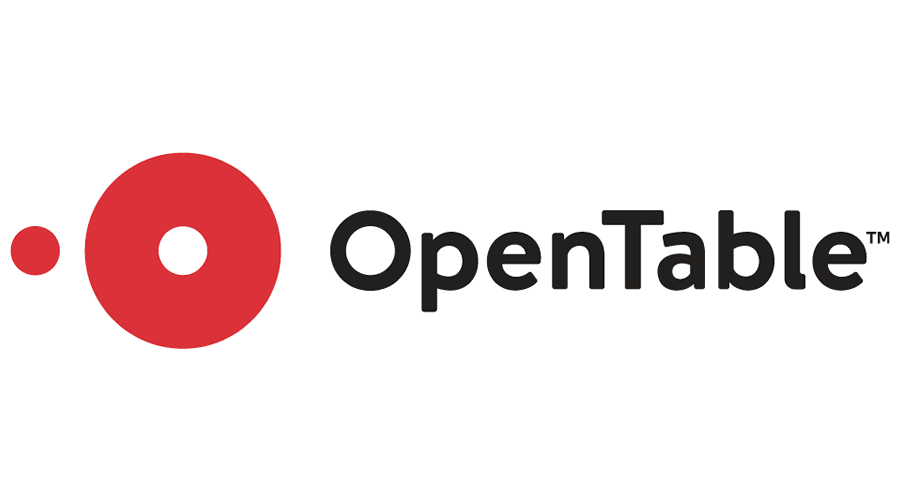

# Overview

When Covid-19 hit the United States in March of 2020, everyone quartinted in their homes and the economy ground to a halt. One of the industries hit hardest by Covid was the food and restaurant industry. Restaurants operate on very small margins to begin with and to have to completely shut down for many months, was crushing, causing many to permanently close. 

# Business Problem

Opening a new restaurant takes a large amount of time and capital and maintaining a restaurant is extreamly difficult due to the long work hours and tight margins. Compounded with Covid, the restaurant industry has been crushed in the last 2 years. 

This analysis is going to look at how different city's politics, as it relates to covid restrictions, has impacted how the city's food industry was affected during and post covid. 

My Stakeholder is the National Restaurant Association. They aim to represent and advocate for the more than 500,000 restaurant businesses they serve by providing services such as Financial, Tax & Audit, Food Safety & Quality Assurance, HR and Sustainability.

My analysis will include at 6 cities: 3 Republican and 3 Democrat. The cities are Miami (R), Dallas (R), Phoenix (R), New Orleans (D), Los Angeles (D), New York (D). 

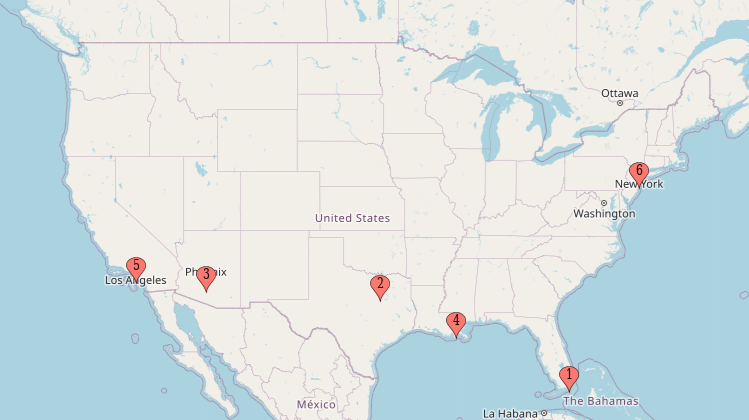

# Data Understanding

In March of 2020, Opentable launched a "State of the Industry" project to illustrate how Covid has impacted restaurants. The data has been updated daily since early 2022 and my analysis includes data from 2/18/20 (when the project launched) through 7/7/22.

Each city included has at least 50+ restaurants on the OpenTable network, however the data does not account for the changes in the number of restaurants on OpenTable per city. Many restaurants permanently closed during covid, which could affect the number or resrvations in of itself because there are less options. However with over 50+ restaurants on the network, it is unlikely this will have a big impact. The data also includes restaurants that have not gone out of business, but have still not reopened to customers, meaning that restaurant will have -100% listed.  

The data analyzed is a daily percent change, year-over-year comparison, with 2019 as the baseline. However, given that the day of the week is relevant for restaurant reservations, the same day of the same week is compared, not the same date. For example, Tuesday of week 11 in 2022 is being compared to to Tuesday of week 11 in 2019.

# Data Limitations

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000)
from datetime import datetime as dt
import matplotlib.ticker as plticker
from io import StringIO
import statsmodels.tsa.stattools as tsa
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
plt.style.use('ggplot')
import pmdarima as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
#import data
df_full = pd.read_csv('Data/Opentable_dataset.csv')

In [4]:
df_full.head(10)

Type            Name 2020/2/18 2020/2/19 2020/2/20 2020/2/21 2020/2/22  \
0  country          Global       -1%        3%       -1%       -2%        1%   
1  country       Australia       -3%       -6%       -3%       -1%        0%   
2  country          Canada       -5%        0%       -3%       -2%       -1%   
3  country         Germany       11%        4%        3%        5%        1%   
4  country         Ireland        2%        0%        4%        1%       -3%   
5  country          Mexico       -5%       -5%       -4%       -3%       -1%   
6  country  United Kingdom        1%       -1%       -2%        0%       -1%   
7  country   United States        0%        4%        0%       -1%        2%   
8    state         Alabama      -14%        7%        1%       -2%        8%   
9    state         Alberta        2%       10%        2%        1%        5%   

  2020/2/23 2020/2/24 2020/2/25 2020/2/26 2020/2/27 2020/2/28 2020/2/29  \
0        4%        1%        1%       -2%       -3%       -1%        1%   
1        0%        0%       -2%       -2%       -7%        0%       -1%   
2        8%       -2%       -3%        1%      -12%       -8%       -4%   
3        2%       11%        4%        5%        5%       11%        7%   
4        4%       -9%       -8%      -10%       -2%      -10%      -13%   
5        2%       -1%       -3%       -9%       -7%      -10%       -5%   
6       -4%       -6%       -5%       -5%       -8%       -2%       -3%   
7        6%        2%        2%       -1%       -1%        1%        3%   
8        2%        1%        0%       -8%       -3%       -3%      -11%   
9        0%       -1%        3%       -1%       -4%        3%        2%   

  2020/3/1 2020/3/2 2020/3/3 2020/3/4 2020/3/5 2020/3/6 2020/3/7 2020/3/8  \
0       0%      -8%      -9%      -6%      -7%      -7%      -4%      -3%   
1       4%     -12%      -6%     -12%      -8%      -6%      -3%      -4%   
2      -7%     -12%      -7%      -2%      -4%      -8%      -9%      -1%   
3       9%      -8%       0%      -4%      -6%      -7%       4%      11%   
4      10%      -6%      -7%      -1%     -15%     -13%      -5%       4%   
5      -7%      -7%     -10%      -6%      -6%      -8%      -2%      -5%   
6      -2%      -7%     -11%      -9%     -12%      -5%      -3%       1%   
7       2%      -7%      -9%      -5%      -5%      -6%      -3%      -2%   
8       2%     -32%     -29%     -23%     -15%      -3%      11%     -10%   
9      -4%     -10%      -4%      -1%      -8%       1%     -16%      -7%   

  2020/3/9 2020/3/10 2020/3/11 2020/3/12 2020/3/13 2020/3/14 2020/3/15  \
0     -14%      -18%      -19%      -28%      -36%      -40%      -47%   
1     -10%       -4%      -10%      -12%       -8%      -11%      -12%   
2     -13%      -18%      -19%      -28%      -40%      -41%      -47%   
3     -10%      -16%      -11%      -17%      -28%      -38%      -46%   
4     -10%      -28%      -27%      -46%      -51%      -52%      -75%   
5     -19%      -16%      -15%      -16%      -16%      -21%      -35%   
6     -18%      -17%      -14%      -24%      -26%      -20%      -31%   
7     -14%      -18%      -19%      -28%      -36%      -42%      -48%   
8     -11%      -26%       -8%       -2%      -24%      -28%      -38%   
9     -13%      -10%       -8%      -23%      -43%      -44%      -49%   

  2020/3/16 2020/3/17 2020/3/18 2020/3/19 2020/3/20 2020/3/21 2020/3/22  \
0      -56%      -83%      -89%   -96.03%   -97.94%   -98.96%   -99.24%   
1      -30%      -43%      -50%      -53%   -51.67%   -53.61%   -65.53%   
2      -60%      -94%      -97%   -99.47%   -99.72%   -99.89%   -99.94%   
3      -63%      -90%      -95%   -98.36%   -98.79%   -99.78%   -99.96%   
4      -70%      -86%      -97%   -98.55%   -99.08%   -98.76%   -98.31%   
5      -48%      -62%      -73%   -78.41%   -85.12%   -90.81%    -95.2%   
6      -52%      -82%      -88%   -91.08%   -93.93%   -99.96%   -99.99%   
7      -56%      -84%      -91%   -9

## Data Setup

In [5]:
#chose 6 cities to model and compare, based on politics and their response to covid and 
#based off June 2022, article "https://www.2foodtrippers.com/best-food-cities-in-the-us/""

In [6]:
#create new dataset wiht just 6 cities

list=['New York', 'Los Angeles', 'Dallas', 'New Orleans', 'Miami', 'Phoenix']

df = df_full[df_full.Name.isin(list)]
df

Type         Name 2020/2/18 2020/2/19 2020/2/20 2020/2/21 2020/2/22  \
45   state     New York       -1%       11%        1%       -4%        1%   
84    city       Dallas        6%       -4%        1%        3%       -3%   
97    city  Los Angeles        7%        6%        9%        1%        8%   
100   city        Miami        0%       -8%       -5%        1%        5%   
108   city  New Orleans       -9%        1%       14%       23%       10%   
109   city     New York        1%       11%        3%        0%        3%   
112   city      Phoenix       -4%        0%       11%       -1%        0%   

    2020/2/23 2020/2/24 2020/2/25 2020/2/26 2020/2/27 2020/2/28 2020/2/29  \
45        13%        6%        1%       -1%       -5%       -2%       -1%   
84        -2%       -2%       14%        1%       -7%        6%       10%   
97        29%       12%       15%        5%        0%        8%       13%   
100       -7%       17%        1%       -9%        0%        0%        4%   
108       21%      109%      102%        9%      -21%      -21%      -16%   
109       13%        7%        1%        1%       -2%        1%       -2%   
112        1%        7%        3%       -2%       -2%        7%       -5%   

    2020/3/1 2020/3/2 2020/3/3 2020/3/4 2020/3/5 2020/3/6 2020/3/7 2020/3/8  \
45        0%      -7%     -11%      -9%      -8%     -14%     -10%      -2%   
84       11%       1%      -6%      -8%       0%       3%      -1%      -2%   
97       -3%      -1%       4%       7%      -5%       1%      -2%     -15%   
100     -18%     -13%     -15%      -6%      -2%     -11%      -2%      10%   
108     -27%     -47%     -59%     -32%       5%       6%       3%      -3%   
109      -2%      -6%     -12%     -12%      -9%     -15%     -10%      -4%   
112     -11%     -13%     -21%      -8%      -8%      -7%      -6%      -8%   

    2020/3/9 2020/3/10 2020/3/11 2020/3/12 2020/3/13 2020/3/14 2020/3/15  \
45      -15%      -27%      -32%      -49%      -54%      -36%      -47%   
84      -15%      -10%      -12%      -25%      -35%      -35%      -42%   
97      -27%      -23%      -26%      -38%      -48%      -47%      -57%   
100      -9%      -15%      -18%      -22%      -27%      -30%      -36%   
108     -13%      -13%      -21%      -28%      -32%      -39%      -54%   
109     -18%      -30%      -36%      -52%      -61%      -64%      -69%   
112     -18%      -13%      -28%      -21%      -28%      -27%      -45%   

    2020/3/16 2020/3/17 2020/3/18 2020/3/19 2020/3/20 2020/3/21 2020/3/22  \
45       -58%      -88%     -100%   -99.98%   -99.96%     -100%     -100%   
84       -61%     -100%     -100%   -99.93%   -99.93%     -100%     -100%   
97       -82%     -100%     -100%     -100%     -100%     -100%     -100%   
100      -46%      -78%     -100%     -100%     -100%     -100%     -100%   
108      -63%     -100%     -100%   -99.96%     -100%     -100%     -100%   
109      -77%     -100%     -100%     -100%     -100%     -100%     -100%   
112      -66%      -86%      -99%   -99.65%   -99.85%     -100%     -100%   

    2020/3/23 2020/3/24 2020/3/25 2020/3/26 2020/3/27 2020/3/28 2020/3/29  \
45      -100%     -100%     -100%     -100%     -100%     -100%     -100%   
84      -100%     -100%     -100%     -100%     -100%     -100%     -100%   
97      -100%     -100%     -100%     -100%     -100%     -100%     -100%   
100     -100%     -100%     -100%     -100%     -100%     -100%     -100%   
108     -100%     -100%     -100%     -100%     -100%     -100%     -100%   
109     -100%     -100%     -100%     -100%     -100%     -100%     -100%   
112     -100%     -100%     -100%     -100%     -100%     -100%     -100%   

    2020/3/30 2020/3/31 2020/4/1 2020/4/2 2020/4/3 2020/4/4 2020/4/5 2020/4/6  \
45      -100%     -100%    -100%    -100%    -100%    -100%    -100%    -100%   
84      -100%     -100%    -100%    -100%    -100%    -100%    -100%    -100%   
97      -100%     -100%    -100%    -100%    -100%   

In [7]:
#since I am only comparing cities, I am dropping index "45" which is NY state
df.drop([45], inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
df.head()

Type         Name 2020/2/18 2020/2/19 2020/2/20 2020/2/21 2020/2/22  \
84   city       Dallas        6%       -4%        1%        3%       -3%   
97   city  Los Angeles        7%        6%        9%        1%        8%   
100  city        Miami        0%       -8%       -5%        1%        5%   
108  city  New Orleans       -9%        1%       14%       23%       10%   
109  city     New York        1%       11%        3%        0%        3%   

    2020/2/23 2020/2/24 2020/2/25 2020/2/26 2020/2/27 2020/2/28 2020/2/29  \
84        -2%       -2%       14%        1%       -7%        6%       10%   
97        29%       12%       15%        5%        0%        8%       13%   
100       -7%       17%        1%       -9%        0%        0%        4%   
108       21%      109%      102%        9%      -21%      -21%      -16%   
109       13%        7%        1%        1%       -2%        1%       -2%   

    2020/3/1 2020/3/2 2020/3/3 2020/3/4 2020/3/5 2020/3/6 2020/3/7 2020/3/8  \
84       11%       1%      -6%      -8%       0%       3%      -1%      -2%   
97       -3%      -1%       4%       7%      -5%       1%      -2%     -15%   
100     -18%     -13%     -15%      -6%      -2%     -11%      -2%      10%   
108     -27%     -47%     -59%     -32%       5%       6%       3%      -3%   
109      -2%      -6%     -12%     -12%      -9%     -15%     -10%      -4%   

    2020/3/9 2020/3/10 2020/3/11 2020/3/12 2020/3/13 2020/3/14 2020/3/15  \
84      -15%      -10%      -12%      -25%      -35%      -35%      -42%   
97      -27%      -23%      -26%      -38%      -48%      -47%      -57%   
100      -9%      -15%      -18%      -22%      -27%      -30%      -36%   
108     -13%      -13%      -21%      -28%      -32%      -39%      -54%   
109     -18%      -30%      -36%      -52%      -61%      -64%      -69%   

    2020/3/16 2020/3/17 2020/3/18 2020/3/19 2020/3/20 2020/3/21 2020/3/22  \
84       -61%     -100%     -100%   -99.93%   -99.93%     -100%     -100%   
97       -82%     -100%     -100%     -100%     -100%     -100%     -100%   
100      -46%      -78%     -100%     -100%     -100%     -100%     -100%   
108      -63%     -100%     -100%   -99.96%     -100%     -100%     -100%   
109      -77%     -100%     -100%     -100%     -100%     -100%     -100%   

    2020/3/23 2020/3/24 2020/3/25 2020/3/26 2020/3/27 2020/3/28 2020/3/29  \
84      -100%     -100%     -100%     -100%     -100%     -100%     -100%   
97      -100%     -100%     -100%     -100%     -100%     -100%     -100%   
100     -100%     -100%     -100%     -100%     -100%     -100%     -100%   
108     -100%     -100%     -100%     -100%     -100%     -100%     -100%   
109     -100%     -100%     -100%     -100%     -100%     -100%     -100%   

    2020/3/30 2020/3/31 2020/4/1 2020/4/2 2020/4/3 2020/4/4 2020/4/5 2020/4/6  \
84      -100%     -100%    -100%    -100%    -100%    -100%    -100%    -100%   
97      -100%     -100%    -100%    -100%    -100%    -100%    -100%    -100%   
100     -100%     -100%    -100%    -100%    -100%    -100%    -100%    -100%   
108     -100%     -100%    -100%    -100%    -100%    -100%    -100%    -100%   
109     -100%     -100%    -100%    -100%    -100%    -100%    -100%    -100%   

    2020/4/7 2020/4/8 2020/4/9 2020/4/10 2020/4/11 2020/4/12 2020/4/13  \
84     -100%    -100%    -100%     -100%   -99.78%     -100%   -99.76%   
97     -100%    -100%    -100%     -100%     -100%     -100%     -100%   
100    -100%    -100%    -100%     -100%     -100%     -100%     -100%   
108    -100%    -100%    -100%     -100%     -100%     -100%     -100%   
109    -100%    -100%    -100%     -100%     -100%     -100%     -100%   

    2020/4/14 2020/4/15 2020/4/16 2020/4/17 2020/4/18 2020/4/19 2020/4/20  \
84      -100%     -100%     -100%   -99.69%     -100%     -100%     -100%   
97      -100%     -100%     -100%     -100%     -100%     -100%     -100%   
100     -100%     -100%     -100%     -100%     -100%     -100% 

In [9]:
#transpose data and set date to index in order to timeseries

In [10]:
df.set_index('Name', inplace = True)

In [11]:
df = df.transpose()

In [12]:
df.head(20)

Name      Dallas Los Angeles Miami New Orleans New York Phoenix
Type        city        city  city        city     city    city
2020/2/18     6%          7%    0%         -9%       1%     -4%
2020/2/19    -4%          6%   -8%          1%      11%      0%
2020/2/20     1%          9%   -5%         14%       3%     11%
2020/2/21     3%          1%    1%         23%       0%     -1%
2020/2/22    -3%          8%    5%         10%       3%      0%
2020/2/23    -2%         29%   -7%         21%      13%      1%
2020/2/24    -2%         12%   17%        109%       7%      7%
2020/2/25    14%         15%    1%        102%       1%      3%
2020/2/26     1%          5%   -9%          9%       1%     -2%
2020/2/27    -7%          0%    0%        -21%      -2%     -2%
2020/2/28     6%          8%    0%        -21%       1%      7%
2020/2/29    10%         13%    4%        -16%      -2%     -5%
2020/3/1     11%         -3%  -18%        -27%      -2%    -11%
2020/3/2      1%         -1%  -13%        -47%      -6%    -13%
2020/3/3     -6%          4%  -15%        -59%     -12%    -21%
2020/3/4     -8%          7%   -6%        -32%     -12%     -8%
2020/3/5      0%         -5%   -2%          5%      -9%     -8%
2020/3/6      3%          1%  -11%          6%     -15%     -7%
2020/3/7     -1%         -2%   -2%          3%     -10%     -6%

In [13]:
#drop row labeled "type" as it is no longer necessary
df = df.drop(["Type"])

In [14]:
#set date to index
df = df.set_index(pd.to_datetime(df.index))

In [15]:
#confirm index is now the date
print(f"Now our index is a {type(df.index)}")

Now our index is a <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 870 entries, 2020-02-18 to 2022-07-06
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Dallas       870 non-null    object
 1   Los Angeles  870 non-null    object
 2   Miami        870 non-null    object
 3   New Orleans  870 non-null    object
 4   New York     870 non-null    object
 5   Phoenix      870 non-null    object
dtypes: object(6)
memory usage: 47.6+ KB


In [17]:
df.describe()

Name   Dallas Los Angeles  Miami New Orleans New York Phoenix
count     870         870    870         870      870     870
unique    788         730    777         777      764     790
top     -100%       -100%  -100%       -100%    -100%   -100%
freq       40          96     59          57       57      50

In [18]:
df.index

DatetimeIndex(['2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
               '2020-02-26', '2020-02-27',
               ...
               '2022-06-27', '2022-06-28', '2022-06-29', '2022-06-30',
               '2022-07-01', '2022-07-02', '2022-07-03', '2022-07-04',
               '2022-07-05', '2022-07-06'],
              dtype='datetime64[ns]', length=870, freq=None)

In [19]:
df[df.columns] = df[df.columns].replace('[%]', '', regex=True).astype(float)/100

In [20]:
df.head()

Name        Dallas  Los Angeles  Miami  New Orleans  New York  Phoenix
2020-02-18    0.06         0.07   0.00        -0.09      0.01    -0.04
2020-02-19   -0.04         0.06  -0.08         0.01      0.11     0.00
2020-02-20    0.01         0.09  -0.05         0.14      0.03     0.11
2020-02-21    0.03         0.01   0.01         0.23      0.00    -0.01
2020-02-22   -0.03         0.08   0.05         0.10      0.03     0.00

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 870 entries, 2020-02-18 to 2022-07-06
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Dallas       870 non-null    float64
 1   Los Angeles  870 non-null    float64
 2   Miami        870 non-null    float64
 3   New Orleans  870 non-null    float64
 4   New York     870 non-null    float64
 5   Phoenix      870 non-null    float64
dtypes: float64(6)
memory usage: 47.6 KB


## Resampling

In [22]:
#Resample the dataframe to be weekly
df_new = df.resample('W').median()

In [23]:
#resampled with median so outliers wouldn't be accounted for

In [24]:
df_new.head()

Name        Dallas  Los Angeles  Miami  New Orleans  New York  Phoenix
2020-02-23   -0.01         0.08  -0.03         0.12      0.03     0.00
2020-03-01    0.06         0.08   0.00        -0.16      0.01    -0.02
2020-03-08   -0.01        -0.01  -0.06        -0.03     -0.10    -0.08
2020-03-15   -0.25        -0.38  -0.22        -0.28     -0.52    -0.27
2020-03-22   -1.00        -1.00  -1.00        -1.00     -1.00    -1.00

## EDA

In [25]:
df_mean = df_new.mean().sort_values(ascending = False)
df_mean

Name
Miami         -0.07
Phoenix       -0.27
Dallas        -0.28
New Orleans   -0.46
Los Angeles   -0.51
New York      -0.65
dtype: float64

<AxesSubplot:title={'center':'Average % Change since 2019'}, ylabel='City'>

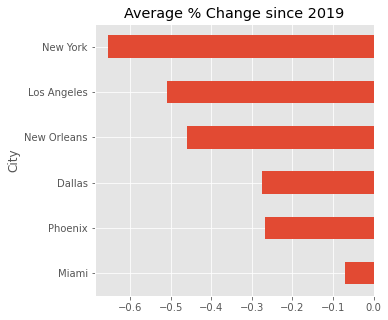

In [26]:
df_mean.plot.barh(y='column', figsize=(5, 5), xlabel = "City", ylabel = "Average % Change", title= "Average % Change since 2019")

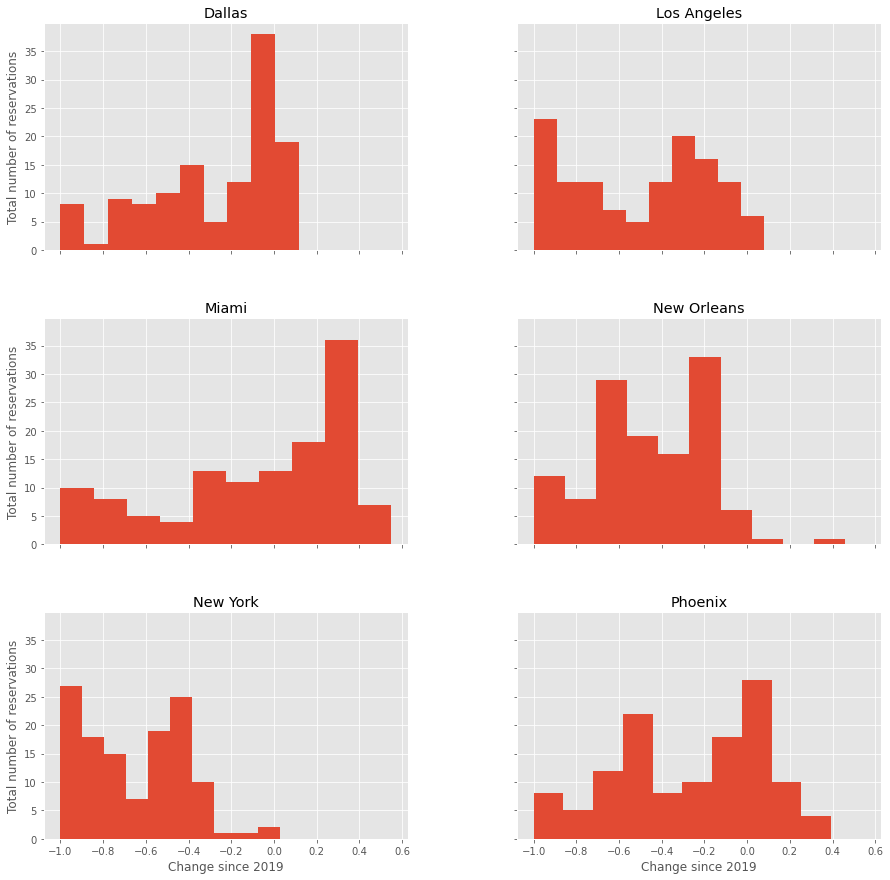

In [27]:
#showing the distribution of reservations per city
hist = df_new.hist(figsize=(15, 15), sharex=True, sharey=True)

for ax in hist.flatten():
    ax.set_xlabel("Change since 2019")
    ax.set_ylabel("Total number of reservations")
    ylabelsize =15
    xlabelsize =15
    
plt.show()

The cities that have histograms with values above 0 are cities that have (at any point) had more reservations YOY since 2019 

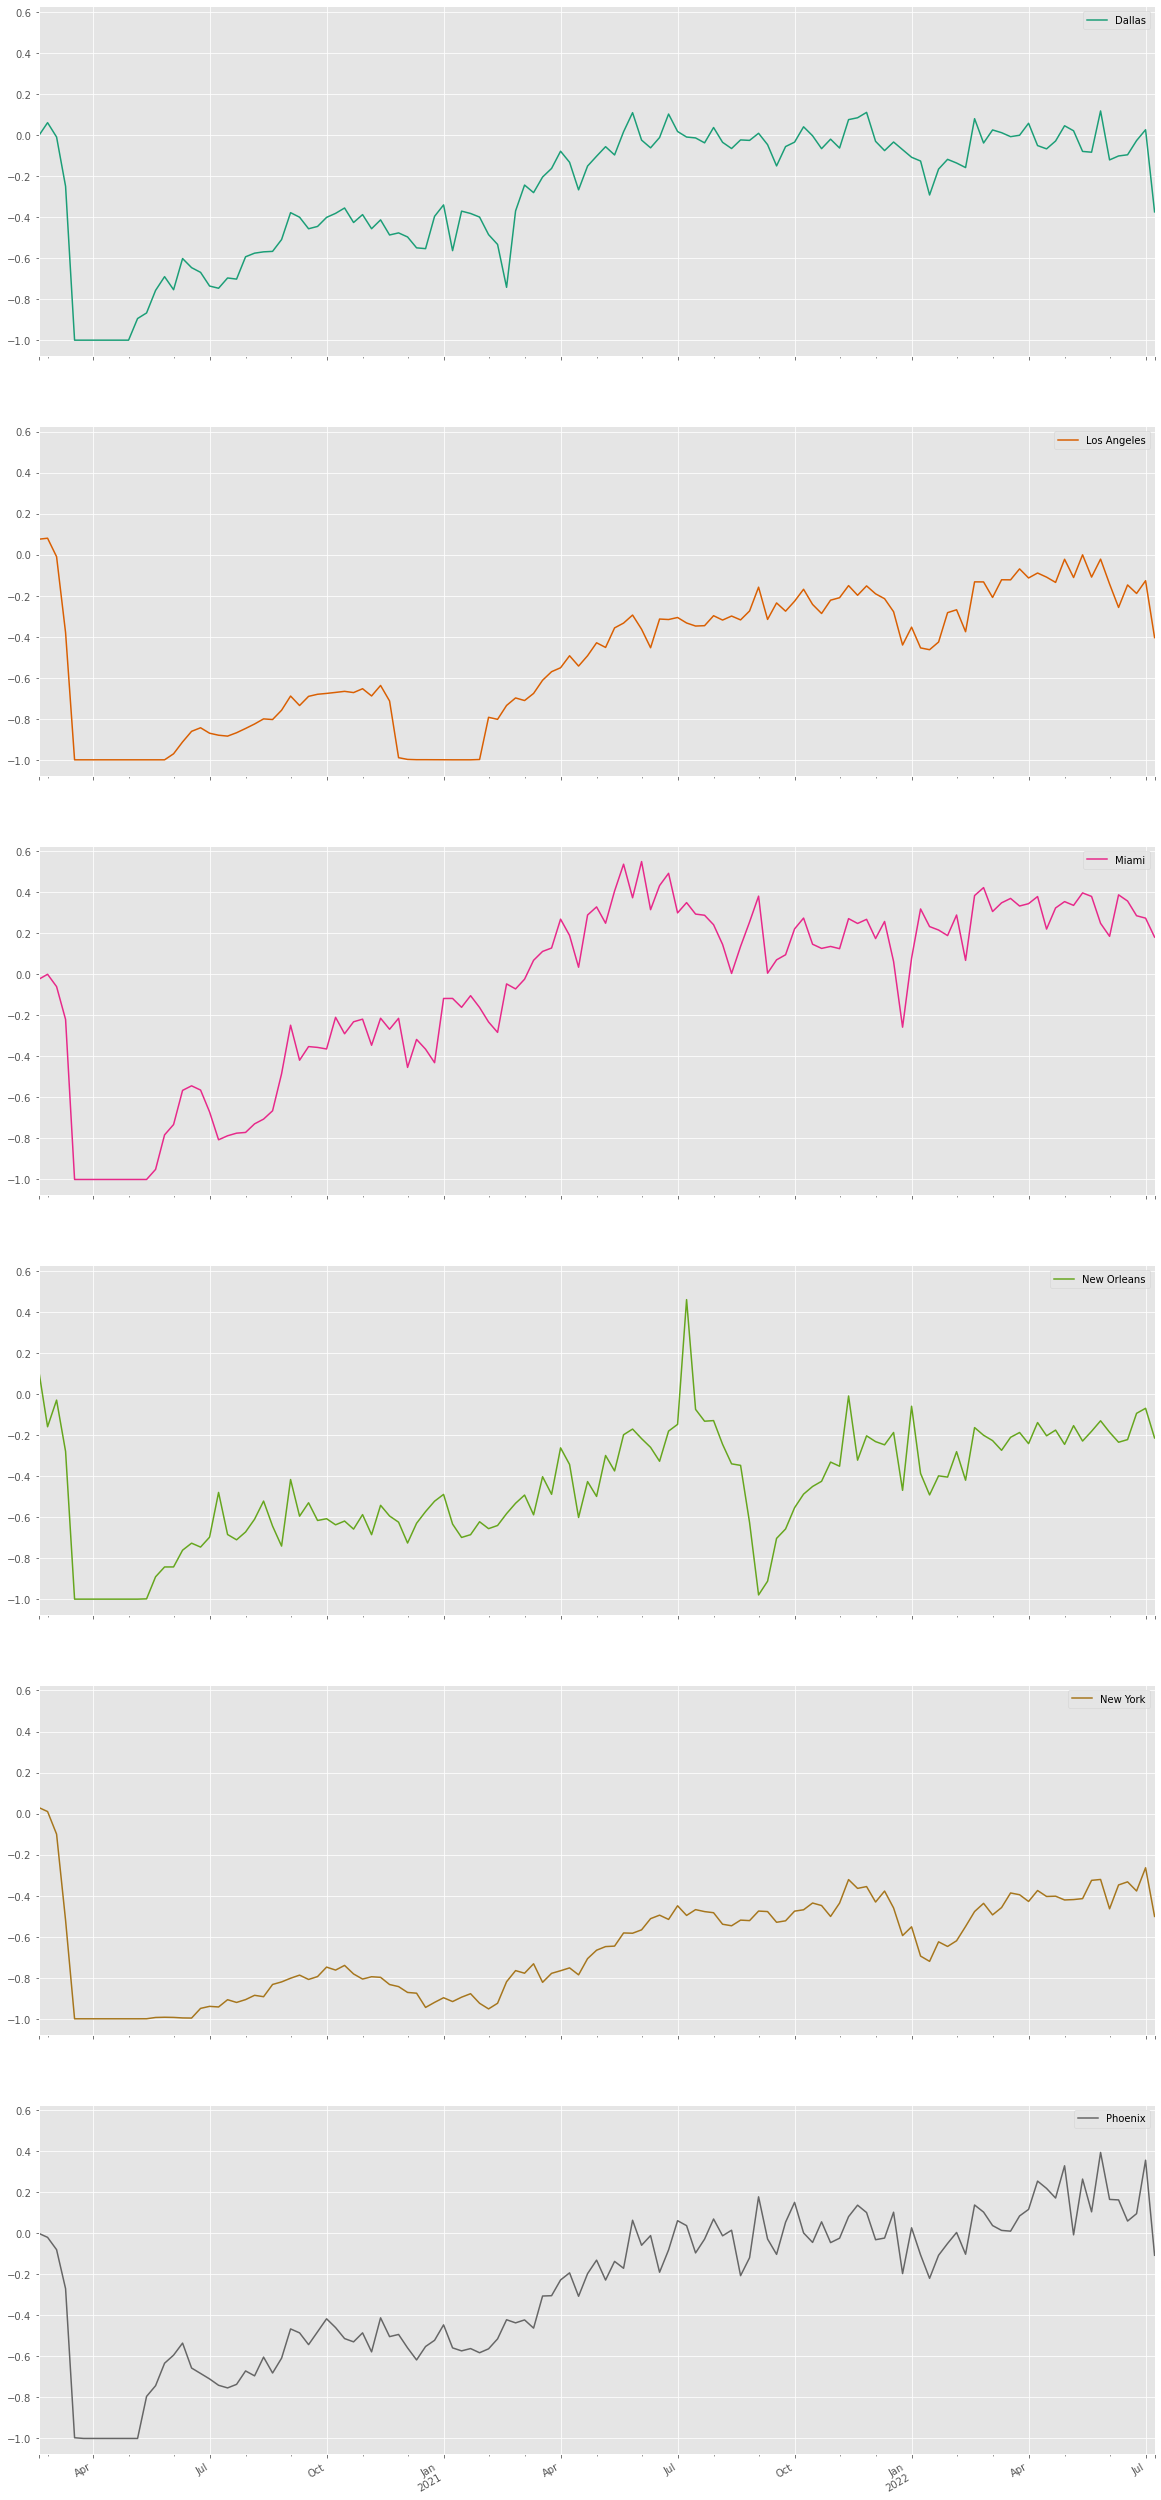

In [28]:
df_new.plot(figsize=(20, 50), colormap = 'Dark2', subplots=True, sharex=True, sharey=True)
plt.show()

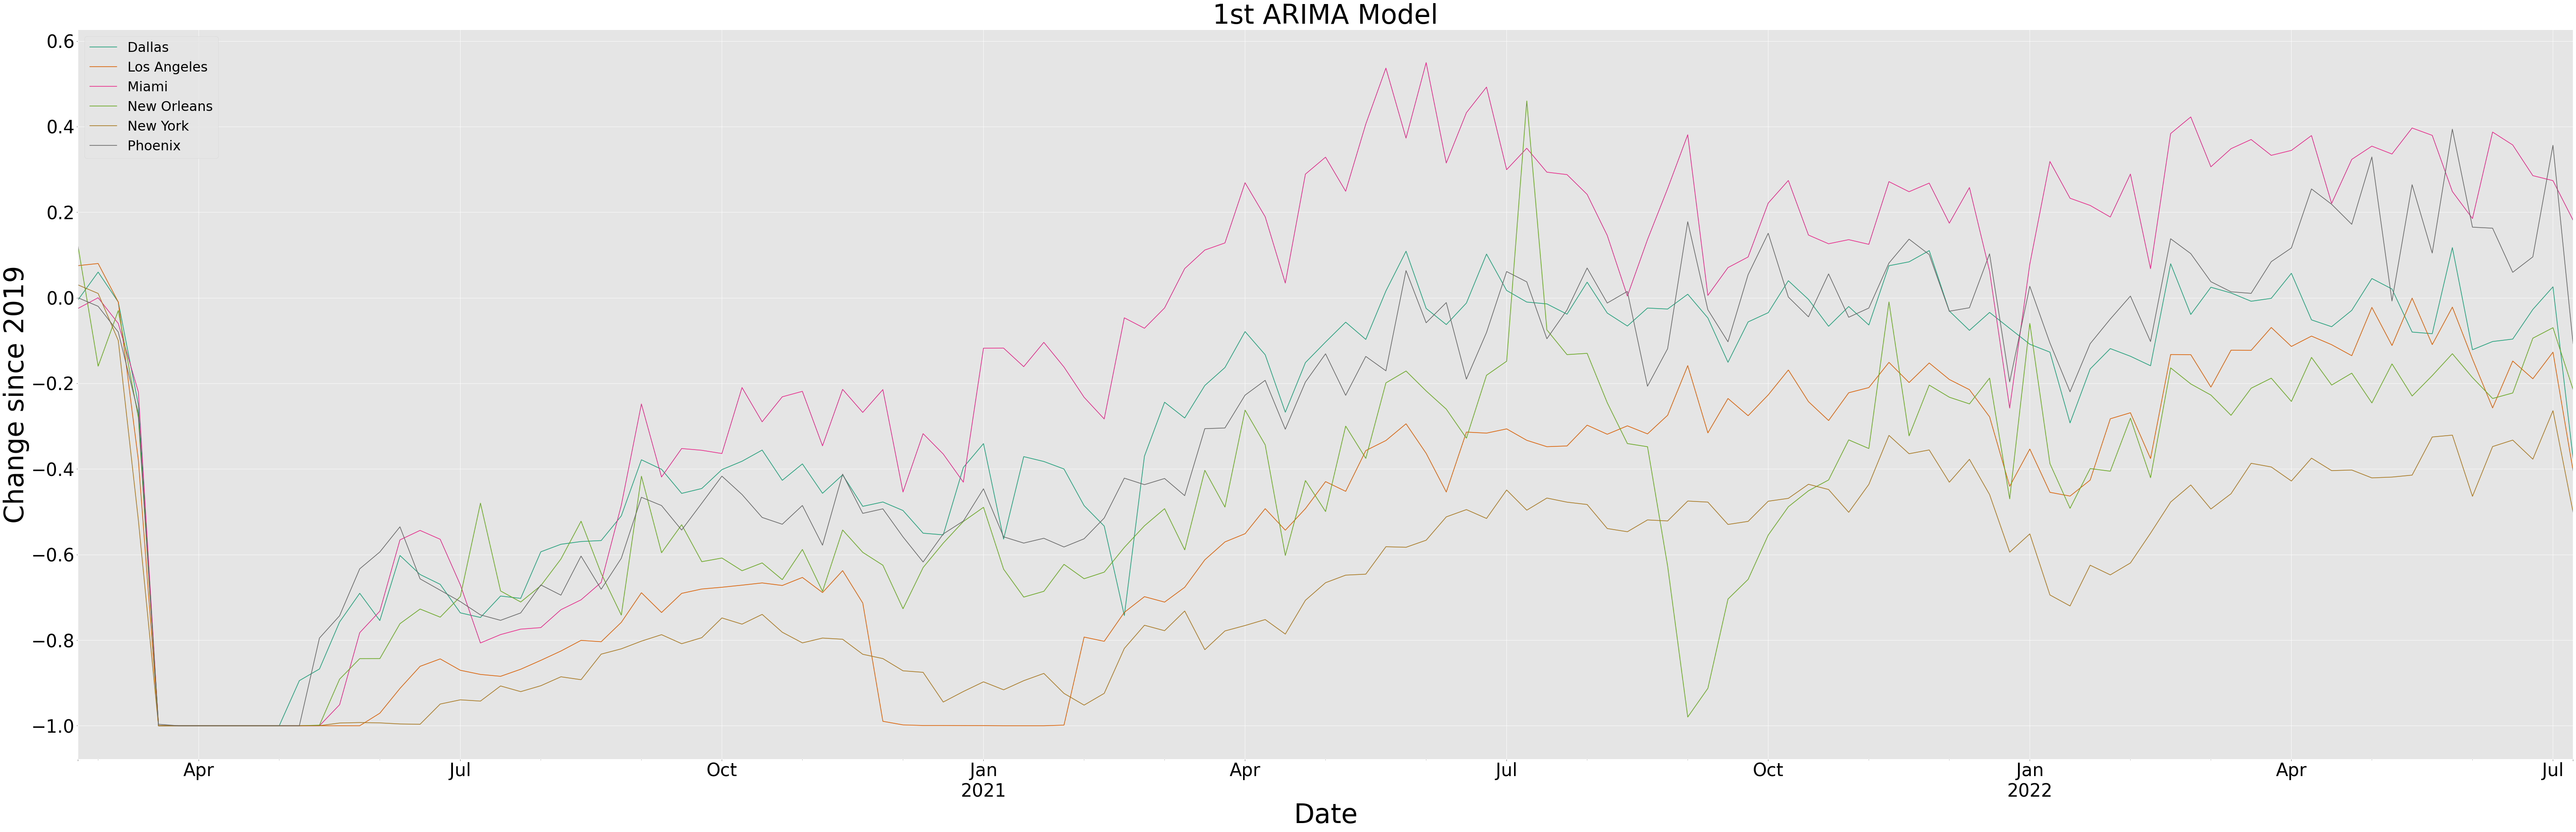

In [29]:
# Plot reservations for all cities  
df_new.plot(figsize=(100, 30), colormap = 'Dark2')
plt.xlabel("Date", fontsize=60, color = 'black')
plt.ylabel("Change since 2019",fontsize=60, color = 'black')
plt.title('1st ARIMA Model', fontsize = 60)
plt.xticks(fontsize = 40, color = 'black')
plt.yticks(fontsize = 40, color = 'black')
plt.legend(fontsize = 30, loc = 2)
plt.show()

This looks like an un-usable mess right now because there are so many data points for so many cities, but as the number of cities gets narrowed down, it will become more legible

## Test for Stationality- Dicky Fuller Test

In [30]:
adf_results = {}
for col in df_new.columns.values:  
    adf_results[col] = tsa.adfuller(df_new[col])

adf_results

{'Dallas': (-1.8827796298196047,
  0.34020497201325317,
  3,
  121,
  {'1%': -3.485585145896754,
   '5%': -2.885738566292665,
   '10%': -2.5796759080663887},
  -211.69802050214093),
 'Los Angeles': (-1.9341942423997849,
  0.3161499251846801,
  7,
  117,
  {'1%': -3.487517288664615,
   '5%': -2.8865777180380032,
   '10%': -2.5801239192052012},
  -263.2411622209577),
 'Miami': (-1.3727807487537735,
  0.5952535896570197,
  2,
  122,
  {'1%': -3.4851223522012855,
   '5%': -2.88553750045158,
   '10%': -2.5795685622144586},
  -154.10655147982357),
 'New Orleans': (-2.650977996844383,
  0.08291207991430016,
  1,
  123,
  {'1%': -3.4846672514209773,
   '5%': -2.8853397507076006,
   '10%': -2.5794629869786503},
  -125.84216376328015),
 'New York': (-2.3528393722627636,
  0.15549174243422942,
  3,
  121,
  {'1%': -3.485585145896754,
   '5%': -2.885738566292665,
   '10%': -2.5796759080663887},
  -338.4368406567406),
 'Phoenix': (-1.7395977827527487,
  0.4108345771337059,
  8,
  116,
  {'1%': -3.4

In [31]:
# loop over dictionary data
non_stationary = []
stationary = []
for key, value in adf_results.items():
    if value[1] > 0.05:
        non_stationary.append(key)
    else:
        stationary.append(key)
print(f'Non-Stationary: {non_stationary}')
print(f'Stationary: {stationary}')

Non-Stationary: ['Dallas', 'Los Angeles', 'Miami', 'New Orleans', 'New York', 'Phoenix']
Stationary: []


## Separate each city into it's own dataframe

In [32]:
NY = df_new['New York']
LA = df_new['Los Angeles']
DAL = df_new['Dallas']
NOLA = df_new['New Orleans']
MIA = df_new['Miami']
PHO = df_new['Phoenix']

## Make Data Stationary

### New York

In [33]:
NY_new = NY.diff().dropna()
NY_new.head()

2020-03-01   -0.02
2020-03-08   -0.11
2020-03-15   -0.42
2020-03-22   -0.48
2020-03-29    0.00
Freq: W-SUN, Name: New York, dtype: float64

In [34]:
dftest = adfuller(NY_new)
display(dftest)

(-6.105322991927242,
 9.615789374613311e-08,
 2,
 121,
 {'1%': -3.485585145896754,
  '5%': -2.885738566292665,
  '10%': -2.5796759080663887},
 -333.4048222565293)

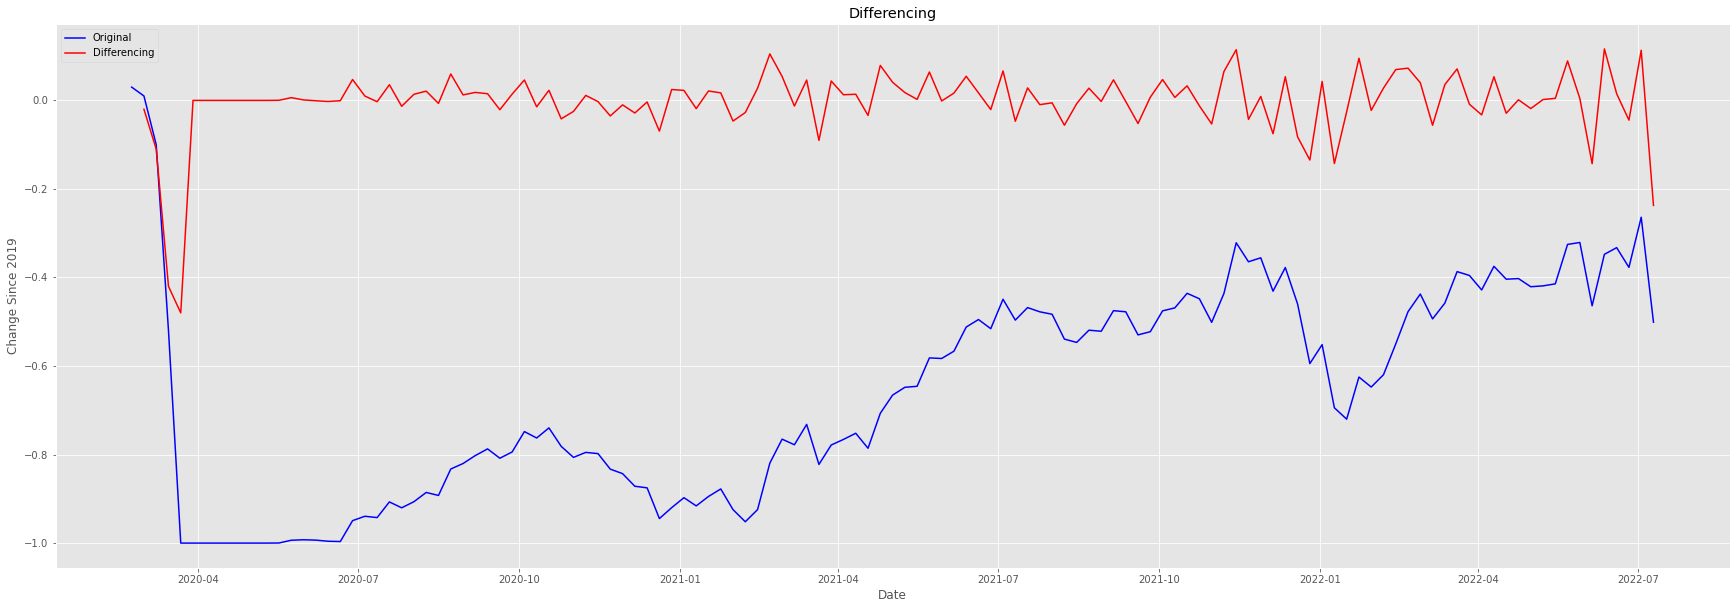

In [35]:
fig = plt.figure(figsize=(30, 10))
orig = plt.plot(NY, color='blue', label='Original')
diff = plt.plot(NY_new, color='red', label='Differencing')
plt.legend(loc='best')
plt.title('Differencing')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
plt.show(block=False)

### Los Angeles

In [36]:
LA_new = LA.diff().dropna()
LA_new.head()

2020-03-01    0.00
2020-03-08   -0.09
2020-03-15   -0.37
2020-03-22   -0.62
2020-03-29    0.00
Freq: W-SUN, Name: Los Angeles, dtype: float64

In [37]:
dftest = adfuller(LA_new)
display(dftest)

(-9.523771110050253,
 3.01584375569297e-16,
 0,
 123,
 {'1%': -3.4846672514209773,
  '5%': -2.8853397507076006,
  '10%': -2.5794629869786503},
 -258.4103080808833)

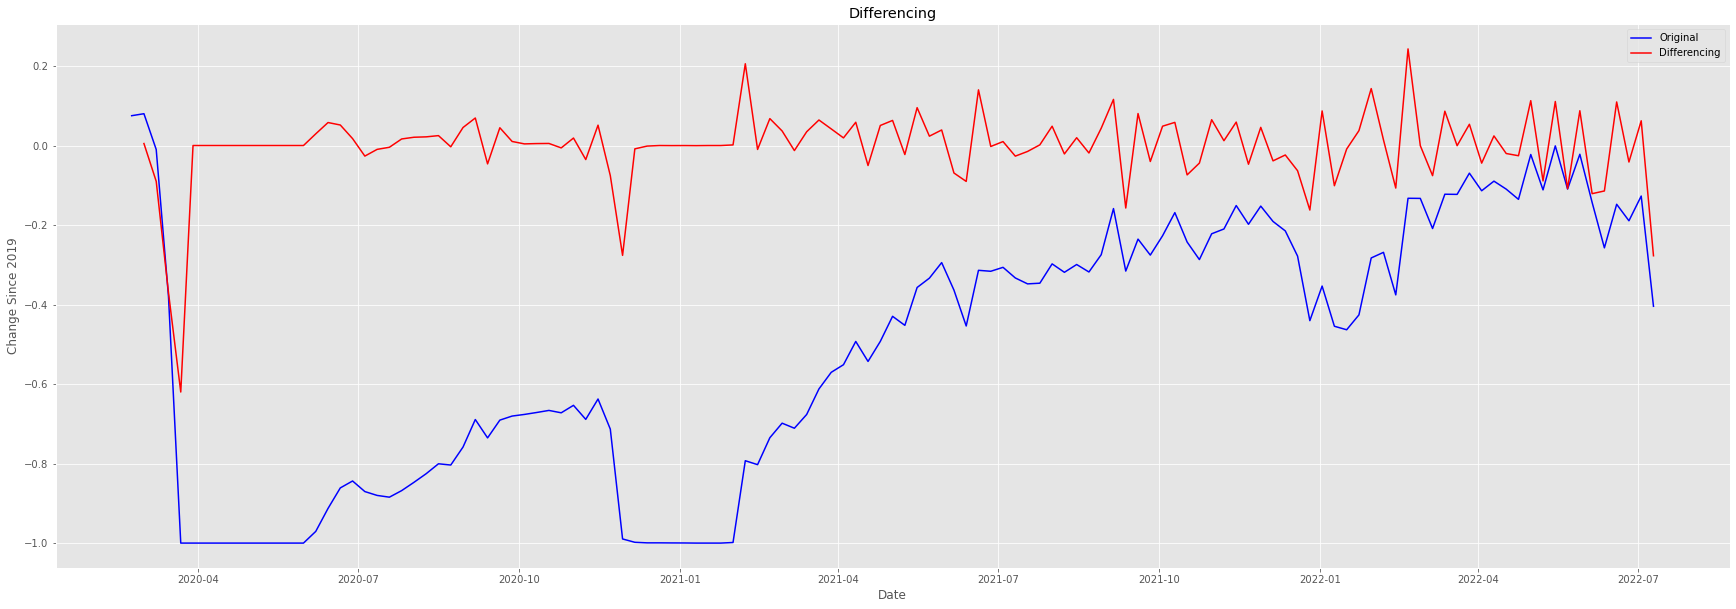

In [38]:
fig = plt.figure(figsize=(30,10))
orig = plt.plot(LA, color='blue', label='Original')
diff = plt.plot(LA_new, color='red', label='Differencing')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
plt.legend(loc='best')
plt.title('Differencing')
plt.show(block=False)

### Dallas

In [39]:
DAL_new = DAL.diff().dropna()
DAL_new.head()

2020-03-01    0.07
2020-03-08   -0.07
2020-03-15   -0.24
2020-03-22   -0.75
2020-03-29    0.00
Freq: W-SUN, Name: Dallas, dtype: float64

In [40]:
dftest = adfuller(DAL_new)
display(dftest)

(-6.76152504733432,
 2.7843641151806702e-09,
 2,
 121,
 {'1%': -3.485585145896754,
  '5%': -2.885738566292665,
  '10%': -2.5796759080663887},
 -206.69770146800215)

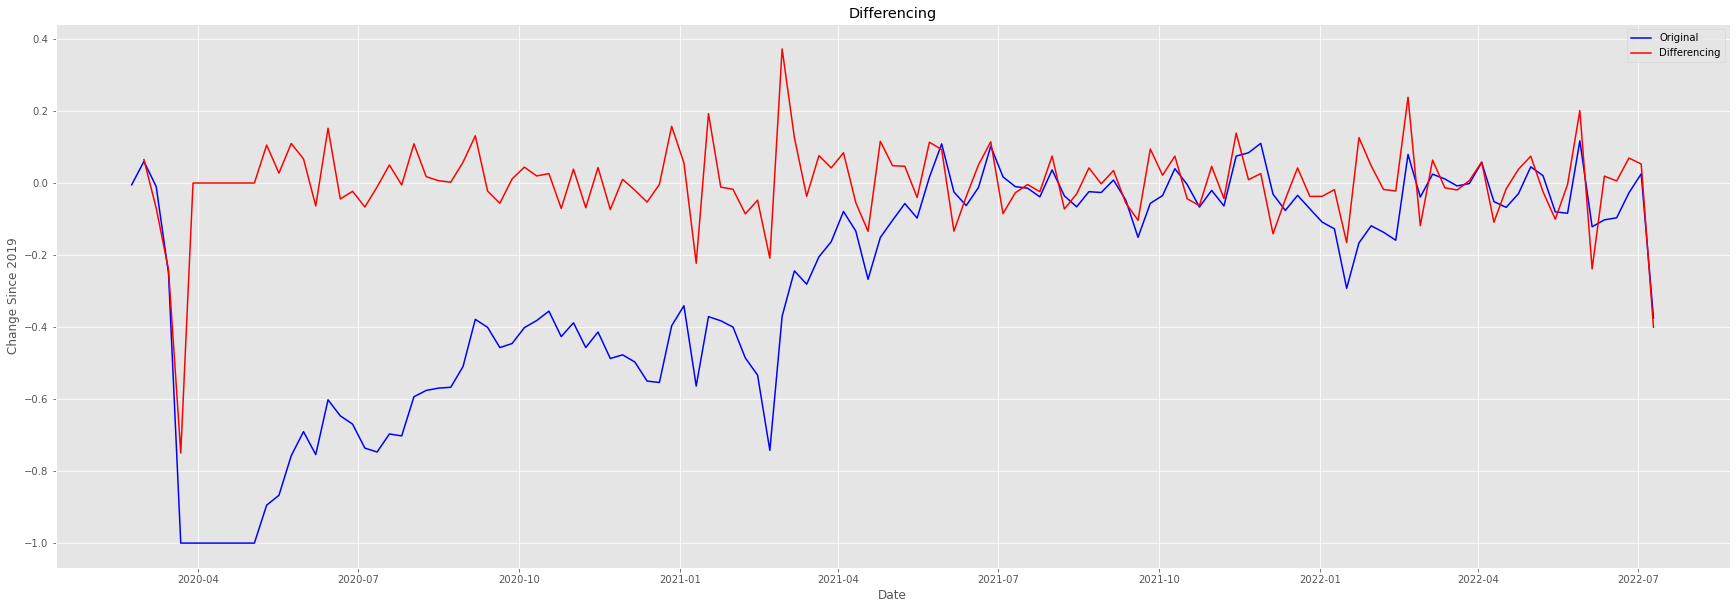

In [41]:
fig = plt.figure(figsize=(30,10))
orig = plt.plot(DAL, color='blue', label='Original')
diff = plt.plot(DAL_new, color='red', label='Differencing')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
plt.title('Differencing')
plt.show(block=False)

### New Orleans

In [42]:
NOLA_new = NOLA.diff().dropna()
NOLA_new.head()

2020-03-01   -0.28
2020-03-08    0.13
2020-03-15   -0.25
2020-03-22   -0.72
2020-03-29    0.00
Freq: W-SUN, Name: New Orleans, dtype: float64

In [43]:
dftest = adfuller(NOLA_new)
display(dftest)

(-14.515877424646723,
 5.626237418900106e-27,
 0,
 123,
 {'1%': -3.4846672514209773,
  '5%': -2.8853397507076006,
  '10%': -2.5794629869786503},
 -118.68515539301112)

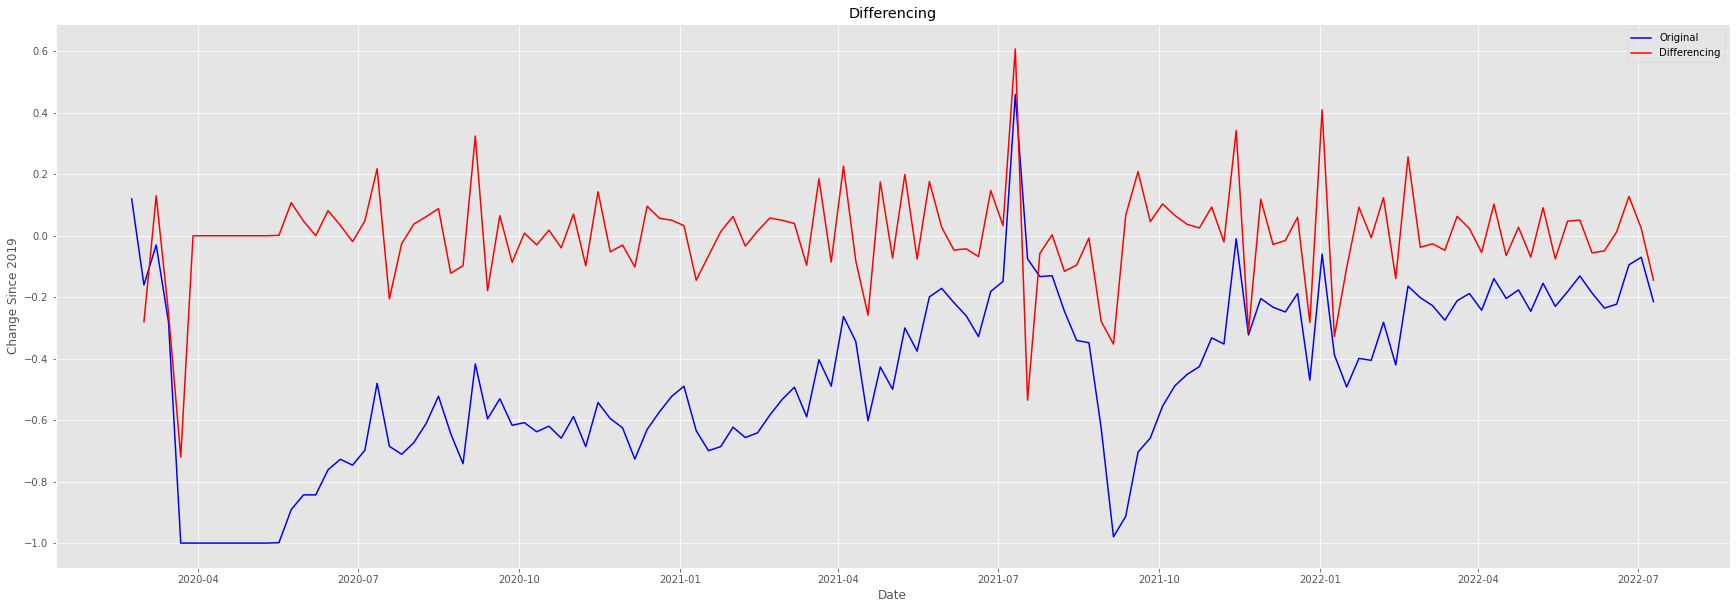

In [44]:
fig = plt.figure(figsize=(30,10))
orig = plt.plot(NOLA, color='blue', label='Original')
diff = plt.plot(NOLA_new, color='red', label='Differencing')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
plt.title('Differencing')
plt.show(block=False)

### Miami

In [45]:
MIA_new = MIA.diff().dropna()
MIA_new.head()

2020-03-01    0.03
2020-03-08   -0.06
2020-03-15   -0.16
2020-03-22   -0.78
2020-03-29    0.00
Freq: W-SUN, Name: Miami, dtype: float64

In [46]:
dftest = adfuller(MIA_new)
display(dftest)

(-9.096009050301145,
 3.713481975098683e-15,
 1,
 122,
 {'1%': -3.4851223522012855,
  '5%': -2.88553750045158,
  '10%': -2.5795685622144586},
 -148.7789852465744)

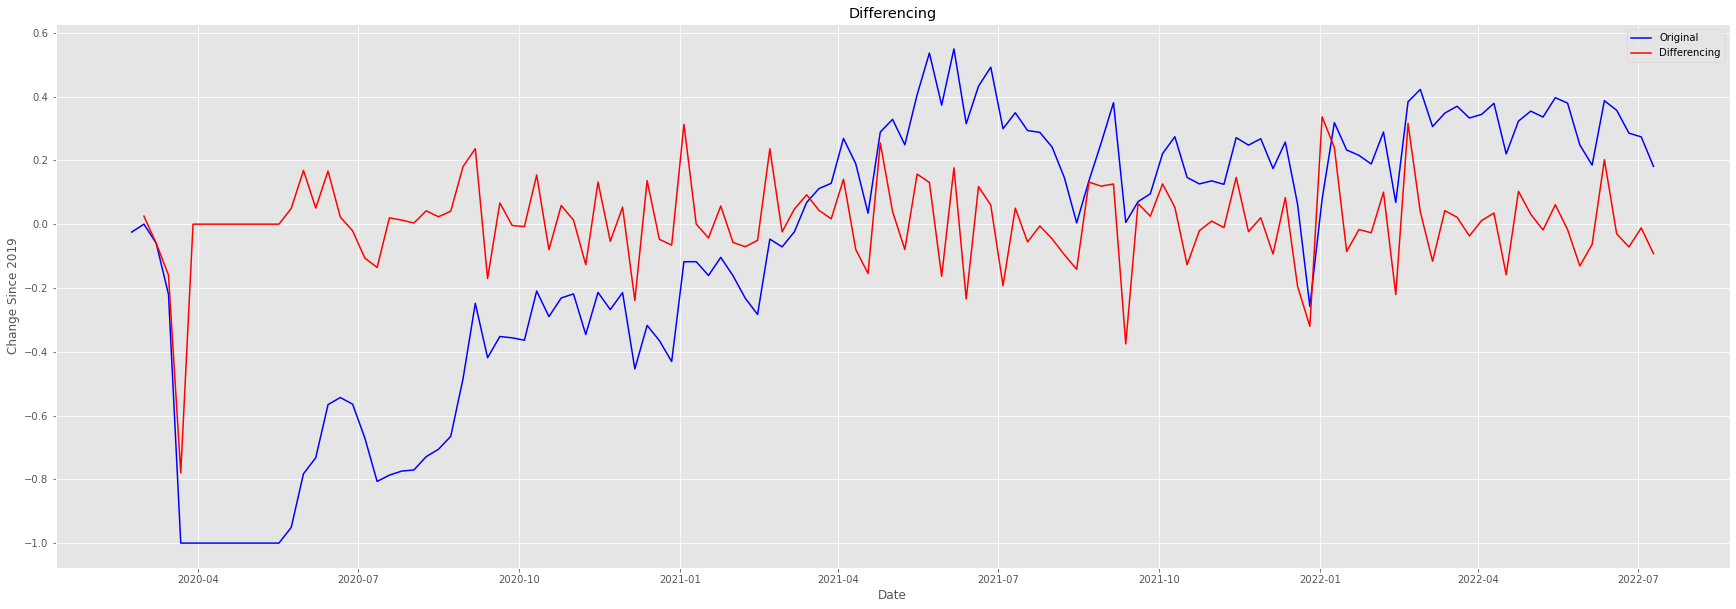

In [47]:
fig = plt.figure(figsize=(30,10))
orig = plt.plot(MIA, color='blue', label='Original')
diff = plt.plot(MIA_new, color='red', label='Differencing')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
plt.title('Differencing')
plt.show(block=False)

### Phoenix

In [48]:
PHO_new = PHO.diff().dropna()
PHO_new.head()

2020-03-01   -0.02
2020-03-08   -0.06
2020-03-15   -0.19
2020-03-22   -0.73
2020-03-29   -0.00
Freq: W-SUN, Name: Phoenix, dtype: float64

In [49]:
dftest = adfuller(PHO_new)
display(dftest)

(-5.959080088802177,
 2.059549600768503e-07,
 7,
 116,
 {'1%': -3.4880216384691867,
  '5%': -2.8867966864160075,
  '10%': -2.5802408234244947},
 -180.7135037091573)

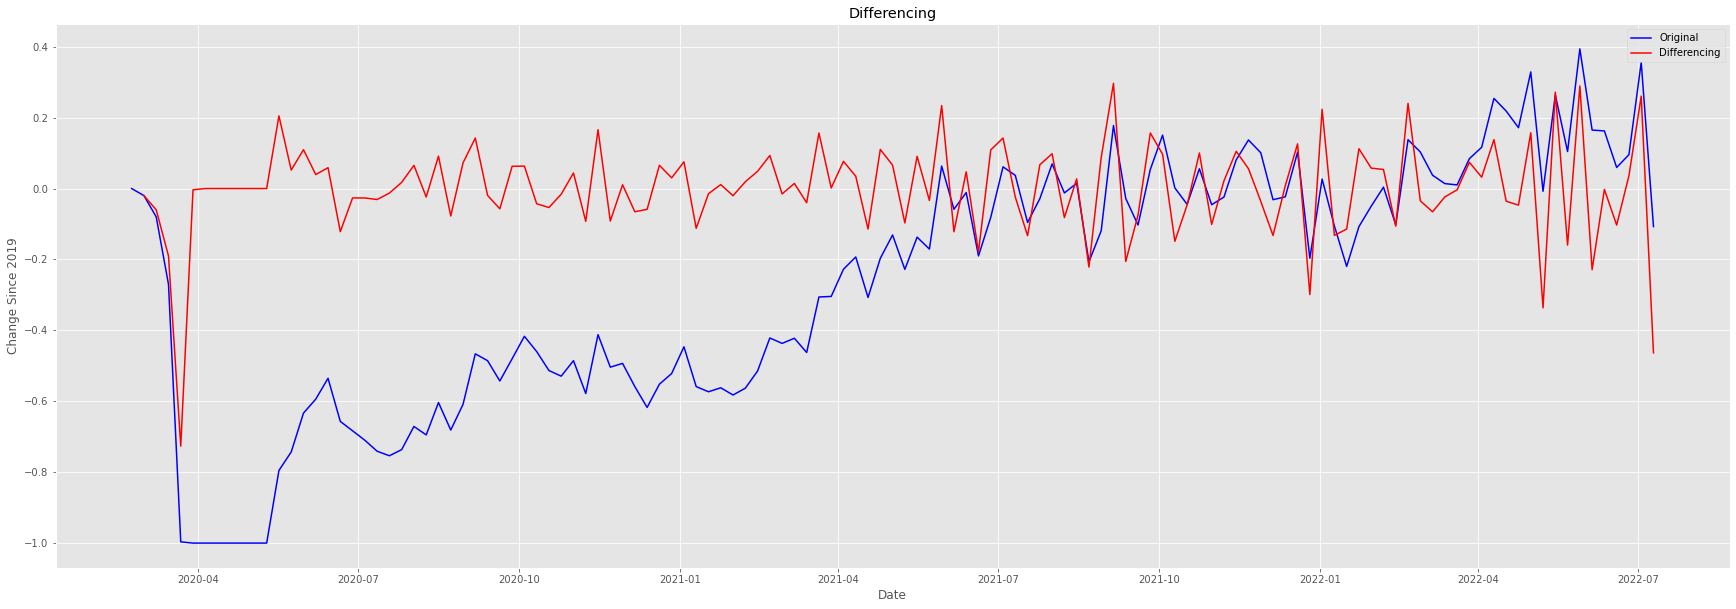

In [50]:
fig = plt.figure(figsize=(30,10))
orig = plt.plot(PHO, color='blue', label='Original')
diff = plt.plot(PHO_new, color='red', label='Differencing')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
plt.title('Differencing')
plt.show(block=False)

## New York City Modeling

In [51]:
# Find the index which allows us to split off 20% of the data
# can use the same variable "cutoff" for the other 5 cities 
# because they all have the same number of rows
cutoff = round(NY.shape[0]*0.8)
cutoff

100

In [52]:
# Define train and test sets according to the index cutoff
NY_train = NY_new[:cutoff]
NY_test = NY_new[cutoff:]

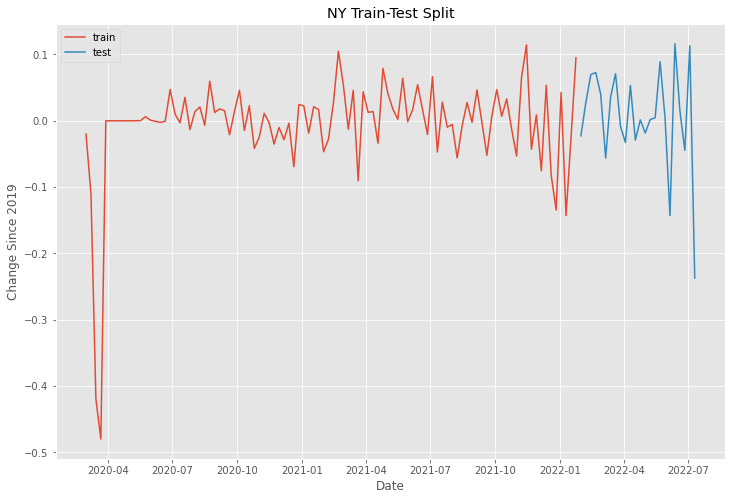

In [53]:
#visualize the train/test split

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(NY_train, label='train')
ax.plot(NY_test, label='test')
ax.set_title('NY Train-Test Split')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
plt.legend();

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


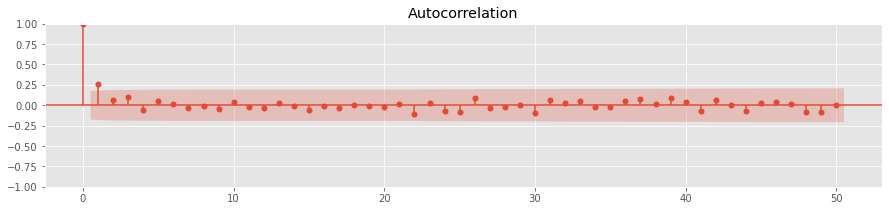

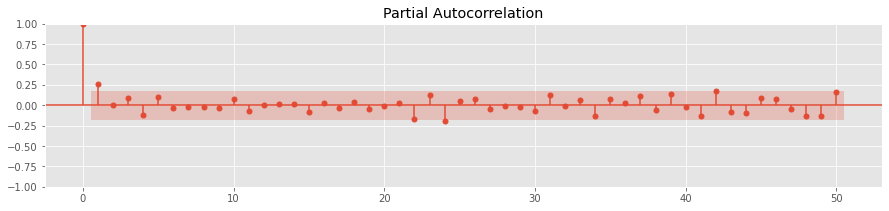

In [54]:
#look at autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(figsize=(15,3))
plot_acf(NY_new, ax=ax, lags=50);

fig, ax = plt.subplots(figsize=(15,3))
plot_pacf(NY_new, ax=ax, lags=50);

In [55]:
#Baseline Model

NY_naive = NY_train.shift(1).dropna()
NY_naive.head()

2020-03-08   -0.02
2020-03-15   -0.11
2020-03-22   -0.42
2020-03-29   -0.48
2020-04-05    0.00
Freq: W-SUN, Name: New York, dtype: float64

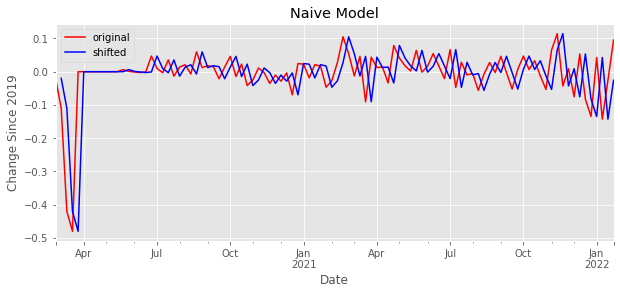

In [56]:
fig, ax = plt.subplots(figsize=(10, 4))

NY_train[0:200].plot(ax=ax, c='r', label='original')
NY_naive[0:200].plot(ax=ax, c='b', label='shifted')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Naive Model')
ax.legend();

In [57]:
NY_naive_rmse = np.sqrt(mean_squared_error(NY_train[1:], NY_naive.dropna()))
NY_naive_rmse

0.08501601037570525

In [58]:
#First ARIMA model based on the autocorrelation and partial autocorrelation plots
NY_AR_1 = ARIMA(NY_train, order=(0, 0, 1)).fit()  
print(NY_AR_1.summary())

                               SARIMAX Results                                
Dep. Variable:               New York   No. Observations:                  100
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 122.854
Date:                Thu, 07 Jul 2022   AIC                           -239.708
Time:                        22:41:35   BIC                           -231.893
Sample:                    03-01-2020   HQIC                          -236.545
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0063      0.014     -0.446      0.655      -0.034       0.021
ma.L1          0.4110      0.056      7.340      0.000       0.301       0.521
sigma2         0.0050      0.000     10.755      0.0

In [59]:
train_preds_1 = NY_AR_1.predict(typ='levels')
test_preds_1 = NY_AR_1.predict(start=NY_test.index[0], end=NY_test.index[-1],typ='levels')

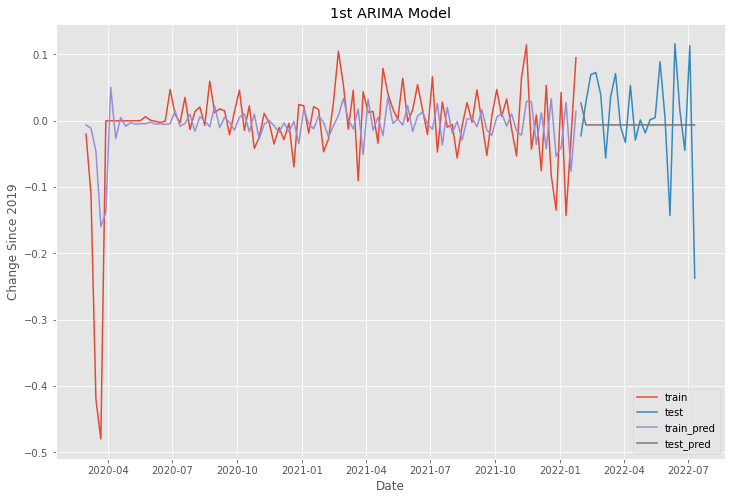

In [60]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(NY_train, label='train')
ax.plot(NY_test, label='test')
ax.plot(train_preds_1, label='train_pred')
ax.plot(test_preds_1, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('1st ARIMA Model')
plt.legend();

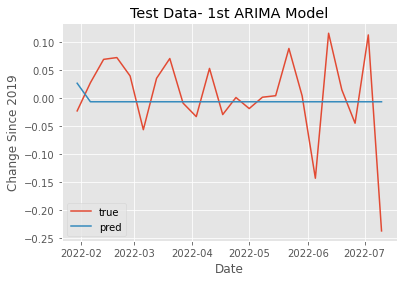

In [61]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(NY_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 1st ARIMA Model')

plt.legend();

In [62]:
NY_AR_1_RMSE = np.sqrt(mean_squared_error(NY_test, test_preds_1))
NY_AR_1_RMSE

0.07790020656340368

In [63]:
#Use auto_model tool to find the optimal ARIMA model 

In [64]:
auto_model = pm.auto_arima(NY_train, start_p=1, start_q=1,
                      test='adf',       
                      max_p=10, max_q=10,
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-239.748, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-226.058, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-241.083, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-241.315, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-239.595, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-237.342, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-239.708, Time=0.05 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.237 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 122.658
Date:                Thu, 07 Jul 2022   AIC                           -241.315
Time:                        22:41:35   BIC                           -236.105
Sample:                

In [65]:
#2nd ARIMA model given the autocorrelation graph above 
NY_AR_2 = ARIMA(NY_train, order=(1,0,0)).fit()  
print(NY_AR_2.summary())

                               SARIMAX Results                                
Dep. Variable:               New York   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 122.673
Date:                Thu, 07 Jul 2022   AIC                           -239.347
Time:                        22:41:35   BIC                           -231.531
Sample:                    03-01-2020   HQIC                          -236.184
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0060      0.017     -0.359      0.720      -0.039       0.027
ar.L1          0.3921      0.039      9.977      0.000       0.315       0.469
sigma2         0.0050      0.000     13.172      0.0

In [66]:
train_preds_2 = NY_AR_2.predict(typ='levels')
test_preds_2 = NY_AR_2.predict(start=NY_test.index[0], end=NY_test.index[-1],typ='levels')

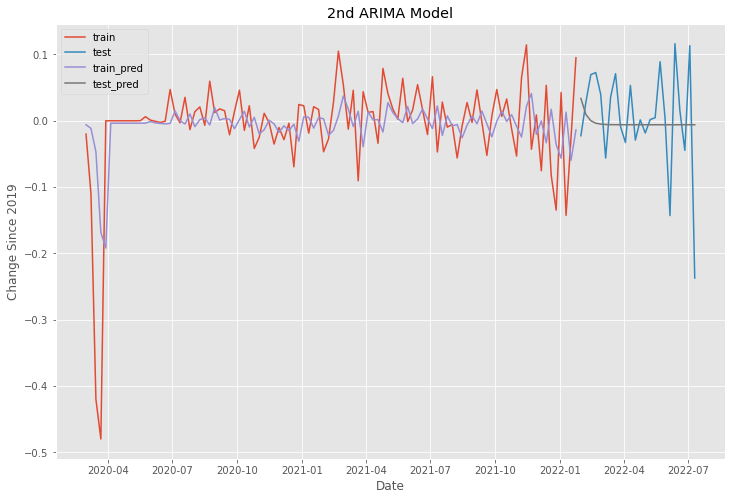

In [67]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(NY_train, label='train')
ax.plot(NY_test, label='test')
ax.plot(train_preds_2, label='train_pred')
ax.plot(test_preds_2, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('2nd ARIMA Model')

plt.legend();

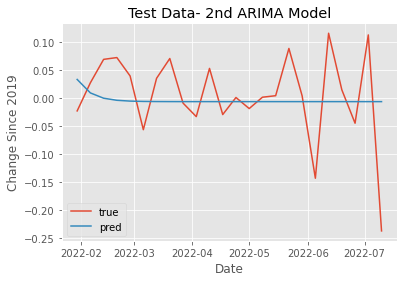

In [68]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(NY_test, label='true')
ax.plot(test_preds_2, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 2nd ARIMA Model')

plt.legend();

In [69]:
NY_AR_2_RMSE = np.sqrt(mean_squared_error(NY_test, test_preds_2))
NY_AR_2_RMSE

0.07747936375511776

In [70]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(NY_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=8,
                         start_P=0, seasonal=True,
                         d=0, trace=True, stationary = True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[8] intercept   : AIC=-236.174, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[8] intercept   : AIC=-224.777, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[8] intercept   : AIC=-237.379, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[8] intercept   : AIC=-237.880, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[8]             : AIC=-226.058, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[8] intercept   : AIC=-239.708, Time=0.03 sec
 ARIMA(0,0,1)(1,0,0)[8] intercept   : AIC=-237.957, Time=0.05 sec
 ARIMA(0,0,1)(1,0,1)[8] intercept   : AIC=-236.367, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[8] intercept   : AIC=-238.066, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[8] intercept   : AIC=-237.942, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[8] intercept   : AIC=-239.347, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[8] intercept   : AIC=-236.289, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[8]             : AIC=-241.315, Time=0.03 sec
 ARIMA(0,0,1)(1,0,0)[8]             : AIC=-239.506, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[8]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 122.658
Date:                Thu, 07 Jul 2022   AIC                           -241.315
Time:                        22:41:37   BIC                           -236.105
Sample:                             0   HQIC                          -239.207
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4133      0.055      7.481      0.000       0.305       0.522
sigma2         0.0050      0.000     12.894      0.000       0.004       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               506.63
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                            -2.39
Prob(H) (two-sided):                  0.03   Kurtosis:                        12.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
NY_SARIMA =SARIMAX(NY_train,
                  order=(1,0,0),
                  seasonal_order=(0,0,0,8),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
print(NY_SARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:               New York   No. Observations:                  100
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 120.937
Date:                Thu, 07 Jul 2022   AIC                           -237.874
Time:                        22:41:37   BIC                           -232.684
Sample:                    03-01-2020   HQIC                          -235.774
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4004      0.035     11.417      0.000       0.332       0.469
sigma2         0.0051      0.000     14.794      0.000       0.004       0.006
Ljung-Box (L1) (Q):                   0.05   Jarque-

In [72]:
train_preds_3 = NY_SARIMA.predict(typ='levels')
test_preds_3 = NY_SARIMA.predict(start=NY_test.index[0], end=NY_test.index[-1],typ='levels')

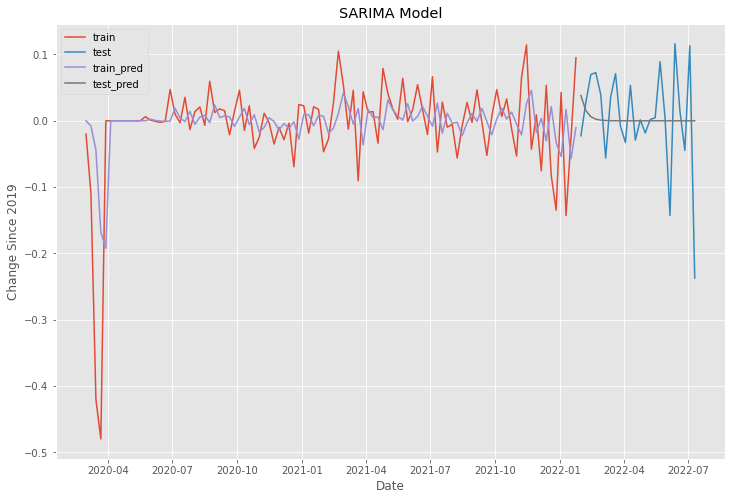

In [73]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(NY_train, label='train')
ax.plot(NY_test, label='test')
ax.plot(train_preds_3, label='train_pred')
ax.plot(test_preds_3, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('SARIMA Model')

plt.legend();

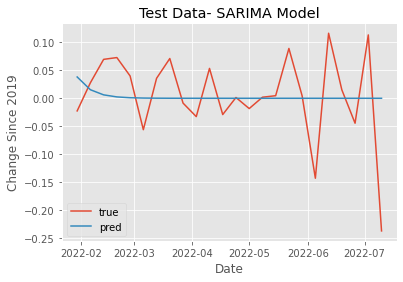

In [74]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(NY_test, label='true')
ax.plot(test_preds_3, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- SARIMA Model')

plt.legend();

In [75]:
NY_SARIMA_RMSE = np.sqrt(mean_squared_error(NY_test, test_preds_3))
NY_SARIMA_RMSE

0.077005257927449

In [76]:
#compiled test scores

In [77]:
print(f'AR_1 AIC: {NY_AR_1.aic}' )
print(f'AR_2 AIC: {NY_AR_2.aic}' )
print(f'SMODEL AIC: {NY_SARIMA.aic}' )

AR_1 AIC: -239.70808916670165
AR_2 AIC: -239.34675200116928
SMODEL AIC: -237.87418760773548


In [78]:
print(f'Naive RMSE: {NY_naive_rmse}')
print(f'AR_1 RMSE: {NY_AR_1_RMSE}' )
print(f'AR_2 RMSE: {NY_AR_2_RMSE}' )
print(f'SMODEL RMSE: {NY_SARIMA_RMSE}' )

Naive RMSE: 0.08501601037570525
AR_1 RMSE: 0.07790020656340368
AR_2 RMSE: 0.07747936375511776
SMODEL RMSE: 0.077005257927449


In [79]:
#final model- SARIMA

In [80]:
#Forecast Error
forecast_error = (NY_test- test_preds_3)
forecast_error

2022-01-30   -0.06
2022-02-06    0.01
2022-02-13    0.06
2022-02-20    0.07
2022-02-27    0.04
2022-03-06   -0.06
2022-03-13    0.04
2022-03-20    0.07
2022-03-27   -0.01
2022-04-03   -0.03
2022-04-10    0.05
2022-04-17   -0.03
2022-04-24    0.00
2022-05-01   -0.02
2022-05-08    0.00
2022-05-15    0.00
2022-05-22    0.09
2022-05-29    0.00
2022-06-05   -0.14
2022-06-12    0.12
2022-06-19    0.02
2022-06-26   -0.04
2022-07-03    0.11
2022-07-10   -0.24
Freq: W-SUN, dtype: float64

In [81]:
#Mean Forecast Error
mean_forecast_error = (NY_test - test_preds_3).mean()
mean_forecast_error

0.0025094847209614023

In [82]:
df_forecast=pd.concat([NY_test, test_preds_3, forecast_error],axis=1)
df_forecast.columns = ['True Test', 'Predicted Test', 'Difference']
df_forecast

True Test  Predicted Test  Difference
2022-01-30      -0.02            0.04       -0.06
2022-02-06       0.03            0.02        0.01
2022-02-13       0.07            0.01        0.06
2022-02-20       0.07            0.00        0.07
2022-02-27       0.04            0.00        0.04
2022-03-06      -0.06            0.00       -0.06
2022-03-13       0.04            0.00        0.04
2022-03-20       0.07            0.00        0.07
2022-03-27      -0.01            0.00       -0.01
2022-04-03      -0.03            0.00       -0.03
2022-04-10       0.05            0.00        0.05
2022-04-17      -0.03            0.00       -0.03
2022-04-24       0.00            0.00        0.00
2022-05-01      -0.02            0.00       -0.02
2022-05-08       0.00            0.00        0.00
2022-05-15       0.00            0.00        0.00
2022-05-22       0.09            0.00        0.09
2022-05-29       0.00            0.00        0.00
2022-06-05      -0.14            0.00       -0.14
2022-06-12       0.12            0.00        0.12
2022-06-19       0.02            0.00        0.02
2022-06-26      -0.04            0.00       -0.04
2022-07-03       0.11            0.00        0.11
2022-07-10      -0.24            0.00       -0.24

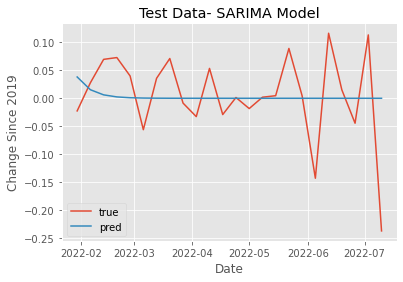

In [83]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(NY_test, label='true')
ax.plot(test_preds_3, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- SARIMA Model')

plt.legend();

## Los Angeles Modeling

In [84]:
# Define train and test sets according to the index cutoff
# using the same index cutoff as NY because all cities have the same number of rows
LA_train = LA_new[:cutoff]
LA_test = LA_new[cutoff:]

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


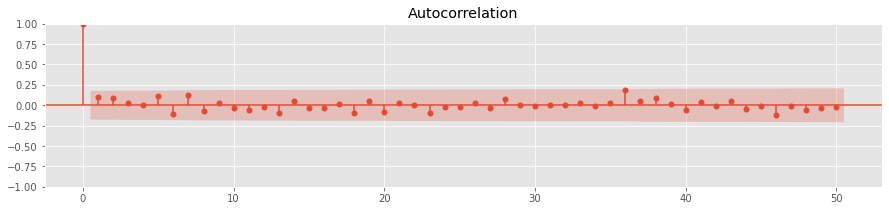

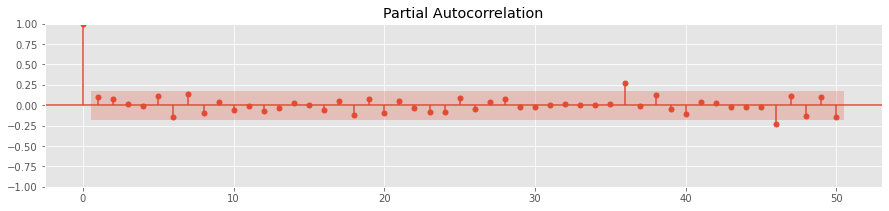

In [85]:
#look at autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(figsize=(15,3))
plot_acf(LA_new, ax=ax, lags=50);

fig, ax = plt.subplots(figsize=(15,3))
plot_pacf(LA_new, ax=ax, lags=50);

In [86]:
#Baseline Model

LA_naive = LA_train.shift(1).dropna()
LA_naive.head()

2020-03-08    0.00
2020-03-15   -0.09
2020-03-22   -0.37
2020-03-29   -0.62
2020-04-05    0.00
Freq: W-SUN, Name: Los Angeles, dtype: float64

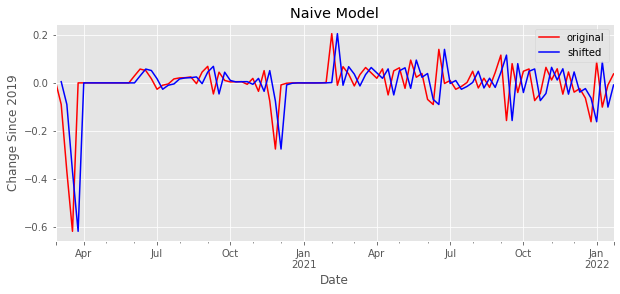

In [87]:
fig, ax = plt.subplots(figsize=(10, 4))

LA_train[0:200].plot(ax=ax, c='r', label='original')
LA_naive[0:200].plot(ax=ax, c='b', label='shifted')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Naive Model')
ax.legend();

In [88]:
LA_naive_rmse = np.sqrt(mean_squared_error(LA_train[1:], LA_naive.dropna()))
LA_naive_rmse

0.11459533898536936

In [89]:
#First ARIMA model based on the autocorrelation and partial autocorrelation plots
LA_AR_1 = ARIMA(LA_train, order=(0, 0, 1)).fit()  
print(LA_AR_1.summary())

                               SARIMAX Results                                
Dep. Variable:            Los Angeles   No. Observations:                  100
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  98.075
Date:                Thu, 07 Jul 2022   AIC                           -190.149
Time:                        22:41:38   BIC                           -182.334
Sample:                    03-01-2020   HQIC                          -186.986
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0049      0.016     -0.308      0.758      -0.036       0.026
ma.L1          0.2389      0.081      2.944      0.003       0.080       0.398
sigma2         0.0082      0.001      9.668      0.0

In [90]:
train_preds_1 = LA_AR_1.predict(typ='levels')
test_preds_1 = LA_AR_1.predict(start=LA_test.index[0], end=LA_test.index[-1],typ='levels')

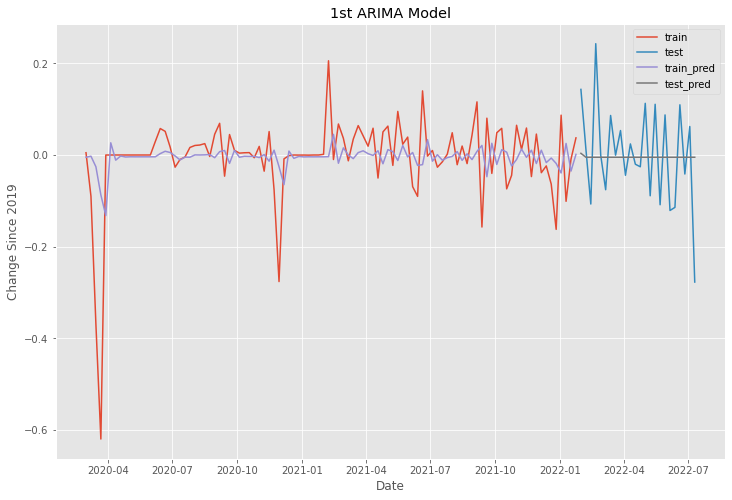

In [91]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(LA_train, label='train')
ax.plot(LA_test, label='test')
ax.plot(train_preds_1, label='train_pred')
ax.plot(test_preds_1, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('1st ARIMA Model')
plt.legend();

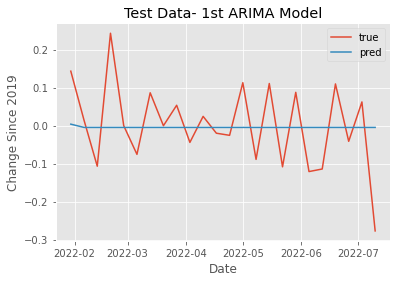

In [92]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(LA_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 1st ARIMA Model')

plt.legend();

In [93]:
LA_AR_1_RMSE = np.sqrt(mean_squared_error(LA_test, test_preds_1))
LA_AR_1_RMSE

0.10873308417023518

In [94]:
#Use auto_model tool to find the optimal ARIMA model 

auto_model = pm.auto_arima(LA_train, start_p=1, start_q=1,
                      test='adf',       
                      max_p=10, max_q=10,
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-190.593, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-187.617, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-192.544, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-191.960, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-190.591, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-188.601, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-190.703, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.201 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  98.272
Date:                Thu, 07 Jul 2022   AIC                           -192.544
Time:                        22:41:38   BIC                           -187.334
Sample:                

In [95]:
#2nd ARIMA model given the autocorrelation graph above 
LA_AR_2 = ARIMA(LA_train, order=(1,0,0)).fit()  
print(LA_AR_2.summary())

                               SARIMAX Results                                
Dep. Variable:            Los Angeles   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  98.351
Date:                Thu, 07 Jul 2022   AIC                           -190.703
Time:                        22:41:38   BIC                           -182.887
Sample:                    03-01-2020   HQIC                          -187.540
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0048      0.017     -0.283      0.777      -0.038       0.029
ar.L1          0.2554      0.059      4.301      0.000       0.139       0.372
sigma2         0.0082      0.001     11.106      0.0

In [96]:
train_preds_2 = LA_AR_2.predict(typ='levels')
test_preds_2 = LA_AR_2.predict(start=LA_test.index[0], end=LA_test.index[-1],typ='levels')

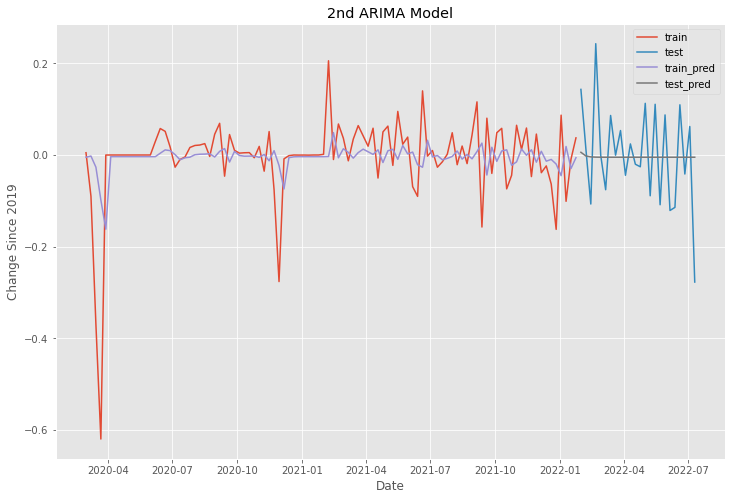

In [97]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(LA_train, label='train')
ax.plot(LA_test, label='test')
ax.plot(train_preds_2, label='train_pred')
ax.plot(test_preds_2, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('2nd ARIMA Model')

plt.legend();

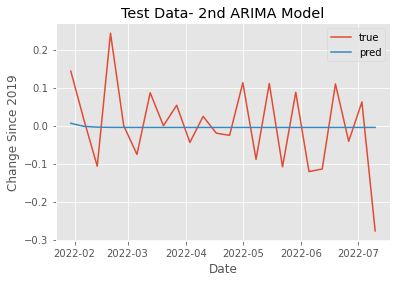

In [98]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(LA_test, label='true')
ax.plot(test_preds_2, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 2nd ARIMA Model')

plt.legend();

In [99]:
LA_AR_2_RMSE = np.sqrt(mean_squared_error(LA_test, test_preds_2))
LA_AR_2_RMSE

0.10860691595371746

In [100]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(LA_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=8,
                         start_P=0, seasonal=True,
                         d=0, trace=True, stationary = True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[8] intercept   : AIC=-186.917, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[8] intercept   : AIC=-185.903, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[8] intercept   : AIC=-188.840, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[8] intercept   : AIC=-188.261, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[8]             : AIC=-187.617, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[8] intercept   : AIC=-190.703, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[8] intercept   : AIC=-188.860, Time=0.03 sec
 ARIMA(1,0,0)(1,0,1)[8] intercept   : AIC=-186.872, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[8] intercept   : AIC=-188.744, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[8] intercept   : AIC=-188.746, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[8] intercept   : AIC=-190.149, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[8] intercept   : AIC=-186.757, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[8]             : AIC=-192.544, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[8]             : AIC=-190.652, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[8]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  98.272
Date:                Thu, 07 Jul 2022   AIC                           -192.544
Time:                        22:41:40   BIC                           -187.334
Sample:                             0   HQIC                          -190.436
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2576      0.057      4.494      0.000       0.145       0.370
sigma2         0.0082      0.001     11.820      0.000       0.007       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               669.85
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -2.48
Prob(H) (two-sided):                  0.02   Kurtosis:                        14.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [101]:
LA_SARIMA =SARIMAX(LA_train,
                  order=(1,0,0),
                  seasonal_order=(0,0,0,8),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
print(LA_SARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:            Los Angeles   No. Observations:                  100
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  96.828
Date:                Thu, 07 Jul 2022   AIC                           -189.655
Time:                        22:41:40   BIC                           -184.465
Sample:                    03-01-2020   HQIC                          -187.555
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2602      0.057      4.528      0.000       0.148       0.373
sigma2         0.0083      0.001     11.746      0.000       0.007       0.010
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [102]:
train_preds_3 = LA_SARIMA.predict(typ='levels')
test_preds_3 = LA_SARIMA.predict(start=LA_test.index[0], end=LA_test.index[-1],typ='levels')

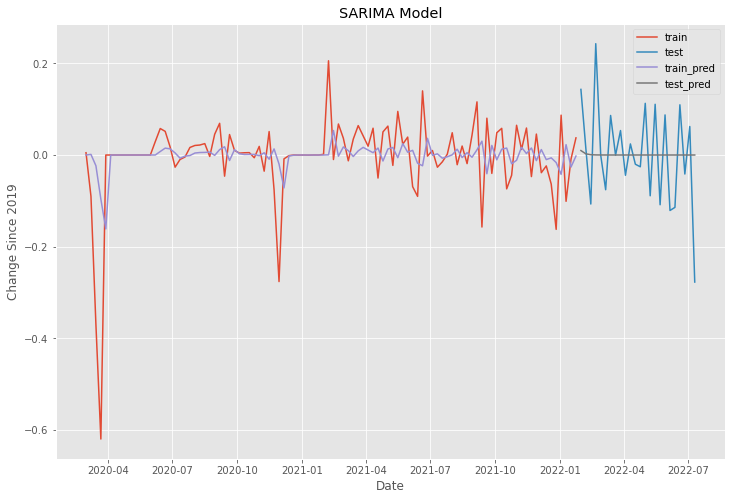

In [103]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(LA_train, label='train')
ax.plot(LA_test, label='test')
ax.plot(train_preds_3, label='train_pred')
ax.plot(test_preds_3, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('SARIMA Model')

plt.legend();

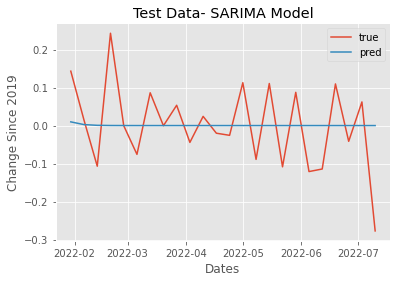

In [104]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(LA_test, label='true')
ax.plot(test_preds_3, label='pred')

plt.xlabel('Dates')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- SARIMA Model')

plt.legend();

In [105]:
LA_SARIMA_RMSE = np.sqrt(mean_squared_error(LA_test, test_preds_3))
LA_SARIMA_RMSE

0.10853975634895732

In [106]:
#compiled test scores

In [107]:
print(f'AR_1 AIC: {LA_AR_1.aic}' )
print(f'AR_2 AIC: {LA_AR_2.aic}' )
print(f'SMODEL AIC: {LA_SARIMA.aic}' )

AR_1 AIC: -190.1492947531565
AR_2 AIC: -190.70281525920504
SMODEL AIC: -189.65529566868483


In [108]:
print(f'Naive RMSE: {LA_naive_rmse}')
print(f'AR_1 RMSE: {LA_AR_1_RMSE}' )
print(f'AR_2 RMSE: {LA_AR_2_RMSE}' )
print(f'SMODEL RMSE: {LA_SARIMA_RMSE}' )

Naive RMSE: 0.11459533898536936
AR_1 RMSE: 0.10873308417023518
AR_2 RMSE: 0.10860691595371746
SMODEL RMSE: 0.10853975634895732


In [109]:
#final model- SARIMA

In [110]:
#Forecast Error
forecast_error = (LA_test- test_preds_3)
forecast_error

2022-01-30    0.13
2022-02-06    0.01
2022-02-13   -0.11
2022-02-20    0.24
2022-02-27   -0.00
2022-03-06   -0.08
2022-03-13    0.09
2022-03-20   -0.00
2022-03-27    0.05
2022-04-03   -0.04
2022-04-10    0.02
2022-04-17   -0.02
2022-04-24   -0.03
2022-05-01    0.11
2022-05-08   -0.09
2022-05-15    0.11
2022-05-22   -0.11
2022-05-29    0.09
2022-06-05   -0.12
2022-06-12   -0.11
2022-06-19    0.11
2022-06-26   -0.04
2022-07-03    0.06
2022-07-10   -0.28
Freq: W-SUN, dtype: float64

In [111]:
#Mean Forecast Error
mean_forecast_error = (LA_test - test_preds_3).mean()
mean_forecast_error

0.00035204565992281767

In [112]:
df_forecast=pd.concat([LA_test, test_preds_3, forecast_error],axis=1)
df_forecast.columns = ['True Test', 'Predicted Test', 'Difference']
df_forecast

True Test  Predicted Test  Difference
2022-01-30       0.14            0.01        0.13
2022-02-06       0.01            0.00        0.01
2022-02-13      -0.11            0.00       -0.11
2022-02-20       0.24            0.00        0.24
2022-02-27      -0.00            0.00       -0.00
2022-03-06      -0.08            0.00       -0.08
2022-03-13       0.09            0.00        0.09
2022-03-20      -0.00            0.00       -0.00
2022-03-27       0.05            0.00        0.05
2022-04-03      -0.04            0.00       -0.04
2022-04-10       0.02            0.00        0.02
2022-04-17      -0.02            0.00       -0.02
2022-04-24      -0.03            0.00       -0.03
2022-05-01       0.11            0.00        0.11
2022-05-08      -0.09            0.00       -0.09
2022-05-15       0.11            0.00        0.11
2022-05-22      -0.11            0.00       -0.11
2022-05-29       0.09            0.00        0.09
2022-06-05      -0.12            0.00       -0.12
2022-06-12      -0.11            0.00       -0.11
2022-06-19       0.11            0.00        0.11
2022-06-26      -0.04            0.00       -0.04
2022-07-03       0.06            0.00        0.06
2022-07-10      -0.28            0.00       -0.28

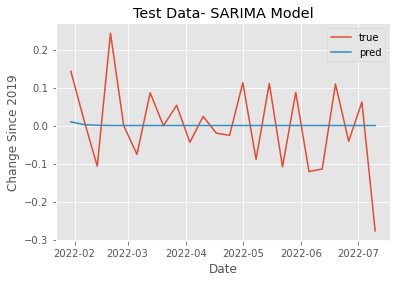

In [113]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(LA_test, label='true')
ax.plot(test_preds_3, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- SARIMA Model')

plt.legend();

## Dallas Modeling

In [114]:
# Define train and test sets according to the index cutoff
# using the same index cutoff as NY because all cities have the same number of rows
DAL_train = DAL_new[:cutoff]
DAL_test = DAL_new[cutoff:]

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


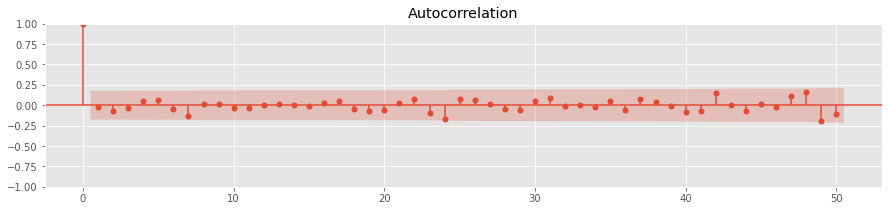

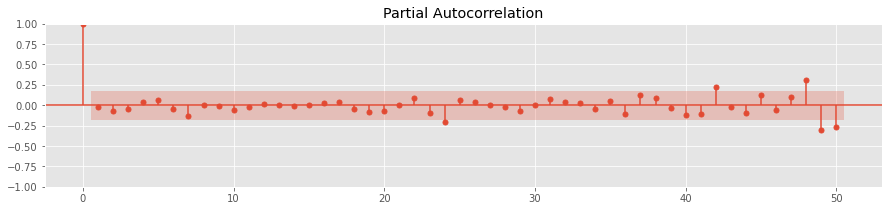

In [115]:
#look at autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(figsize=(15,3))
plot_acf(DAL_new, ax=ax, lags=50);

fig, ax = plt.subplots(figsize=(15,3))
plot_pacf(DAL_new, ax=ax, lags=50);

In [116]:
#Baseline Model

DAL_naive = DAL_train.shift(1).dropna()
DAL_naive.head()

2020-03-08    0.07
2020-03-15   -0.07
2020-03-22   -0.24
2020-03-29   -0.75
2020-04-05    0.00
Freq: W-SUN, Name: Dallas, dtype: float64

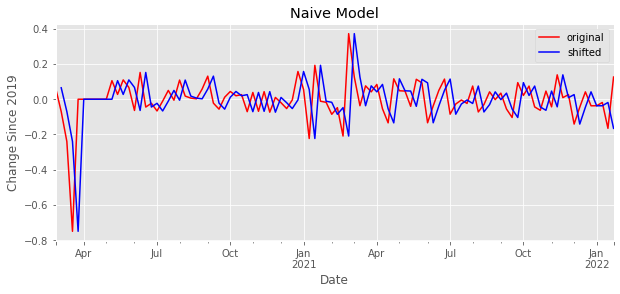

In [117]:
fig, ax = plt.subplots(figsize=(10, 4))

DAL_train[0:200].plot(ax=ax, c='r', label='original')
DAL_naive[0:200].plot(ax=ax, c='b', label='shifted')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Naive Model')
ax.legend();

In [118]:
DAL_naive_rmse = np.sqrt(mean_squared_error(DAL_train[1:], DAL_naive.dropna()))
DAL_naive_rmse

0.1597009588657071

In [119]:
#First ARIMA model based on the autocorrelation and partial autocorrelation plots
DAL_AR_1 = ARIMA(DAL_train, order=(0, 0, 1)).fit()  
print(DAL_AR_1.summary())

                               SARIMAX Results                                
Dep. Variable:                 Dallas   No. Observations:                  100
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  73.768
Date:                Thu, 07 Jul 2022   AIC                           -141.536
Time:                        22:41:41   BIC                           -133.721
Sample:                    03-01-2020   HQIC                          -138.373
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.017     -0.086      0.931      -0.036       0.033
ma.L1          0.0574      0.106      0.543      0.587      -0.150       0.265
sigma2         0.0134      0.001     15.196      0.0

In [120]:
train_preds_1 = DAL_AR_1.predict(typ='levels')
test_preds_1 = DAL_AR_1.predict(start=DAL_test.index[0], end=DAL_test.index[-1],typ='levels')

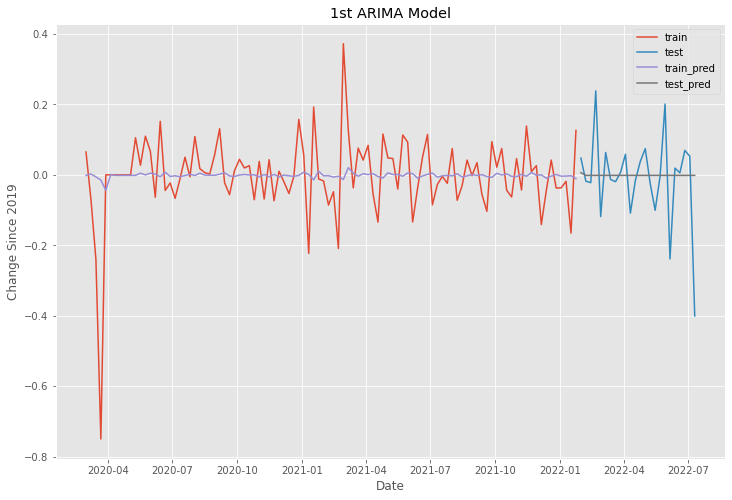

In [121]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(DAL_train, label='train')
ax.plot(DAL_test, label='test')
ax.plot(train_preds_1, label='train_pred')
ax.plot(test_preds_1, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('1st ARIMA Model')
plt.legend();

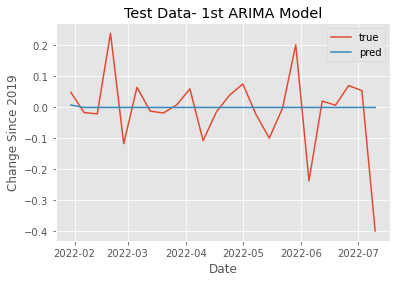

In [122]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(DAL_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 1st ARIMA Model')

plt.legend();

In [123]:
DAL_AR_1_RMSE = np.sqrt(mean_squared_error(DAL_test, test_preds_1))
DAL_AR_1_RMSE

0.12519988955215902

In [124]:
#Use auto_model tool to find the optimal ARIMA model 

auto_model = pm.auto_arima(DAL_train, start_p=1, start_q=1,
                      test='adf',       
                      max_p=10, max_q=10,
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-141.572, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-145.215, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-143.495, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-143.521, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-143.235, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.168 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                        SARIMAX   Log Likelihood                  73.608
Date:                Thu, 07 Jul 2022   AIC                           -145.215
Time:                        22:41:41   BIC                           -142.610
Sample:                             0   HQIC                          -144.161
                                - 100                                       

In [125]:
#2nd ARIMA model given the autocorrelation graph above 
DAL_AR_2 = ARIMA(DAL_train, order=(0,0,0)).fit()  
print(DAL_AR_2.summary())

                               SARIMAX Results                                
Dep. Variable:                 Dallas   No. Observations:                  100
Model:                          ARIMA   Log Likelihood                  73.617
Date:                Thu, 07 Jul 2022   AIC                           -143.235
Time:                        22:41:41   BIC                           -138.025
Sample:                    03-01-2020   HQIC                          -141.126
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.014     -0.115      0.909      -0.029       0.026
sigma2         0.0134      0.001     17.588      0.000       0.012       0.015
Ljung-Box (L1) (Q):                   0.28   Jarque-

In [126]:
train_preds_2 = DAL_AR_2.predict(typ='levels')
test_preds_2 = DAL_AR_2.predict(start=DAL_test.index[0], end=DAL_test.index[-1],typ='levels')

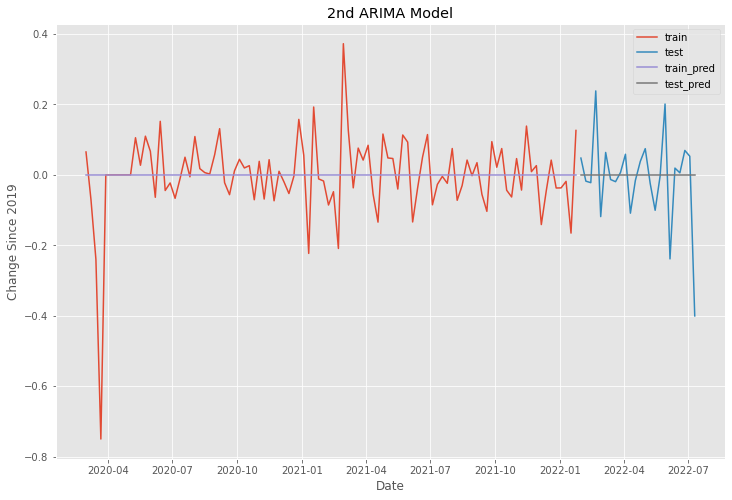

In [127]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(DAL_train, label='train')
ax.plot(DAL_test, label='test')
ax.plot(train_preds_2, label='train_pred')
ax.plot(test_preds_2, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('2nd ARIMA Model')

plt.legend();

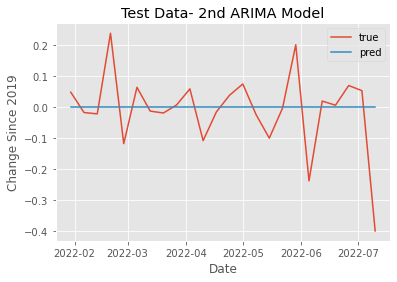

In [128]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(DAL_test, label='true')
ax.plot(test_preds_2, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 2nd ARIMA Model')

plt.legend();

In [129]:
DAL_AR_2_RMSE = np.sqrt(mean_squared_error(DAL_test, test_preds_2))
DAL_AR_2_RMSE

0.12531099491586925

In [130]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(DAL_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=8,
                         start_P=0, seasonal=True,
                         d=0, trace=True, stationary = True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[8] intercept   : AIC=-137.738, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[8] intercept   : AIC=-143.235, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[8] intercept   : AIC=-139.653, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[8] intercept   : AIC=-139.677, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[8]             : AIC=-145.215, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[8] intercept   : AIC=-141.440, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[8] intercept   : AIC=-141.440, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[8] intercept   : AIC=-141.336, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[8] intercept   : AIC=-141.510, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[8] intercept   : AIC=-141.536, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[8] intercept   : AIC=-139.587, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[8]          
Total fit time: 0.589 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                        SARIMAX   Log Likelihood                  73.608
Date:                Thu, 07 Jul 2022   AIC                           -145.215
Time:                        22:41:42   BIC                           -142.610
Sample:                             0   HQIC                          -144.161
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0134      0.001     21.465      0.000       0.012       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):              1206.04
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -2.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [131]:
DAL_SARIMA =SARIMAX(DAL_train,
                  order=(0,0,0),
                  seasonal_order=(0,0,0,8),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
print(DAL_SARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                 Dallas   No. Observations:                  100
Model:                        SARIMAX   Log Likelihood                  72.530
Date:                Thu, 07 Jul 2022   AIC                           -143.060
Time:                        22:41:42   BIC                           -140.465
Sample:                    03-01-2020   HQIC                          -142.010
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0135      0.001     21.316      0.000       0.012       0.015
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):              1176.37
Prob(Q):                              0.57   Pr

In [132]:
train_preds_3 = DAL_SARIMA.predict(typ='levels')
test_preds_3 = DAL_SARIMA.predict(start=DAL_test.index[0], end=DAL_test.index[-1],typ='levels')

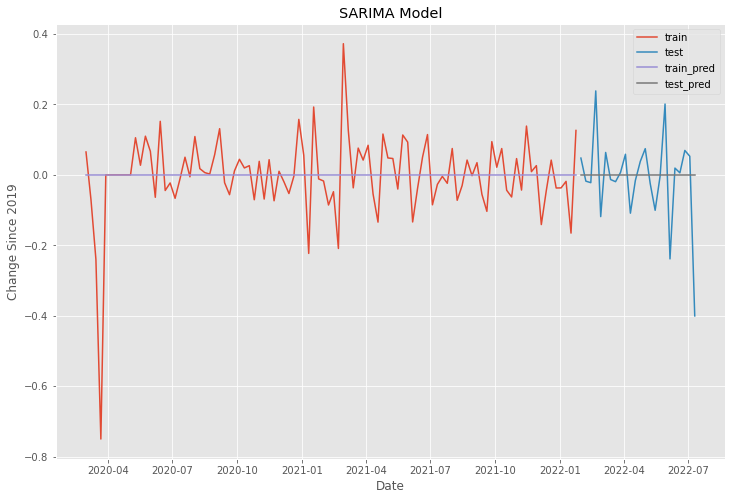

In [133]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(DAL_train, label='train')
ax.plot(DAL_test, label='test')
ax.plot(train_preds_3, label='train_pred')
ax.plot(test_preds_3, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('SARIMA Model')

plt.legend();

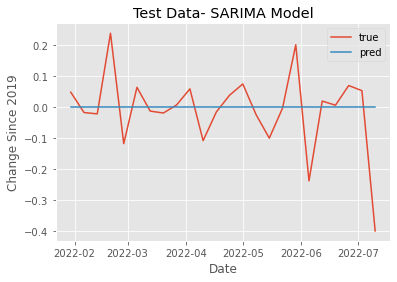

In [134]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(DAL_test, label='true')
ax.plot(test_preds_3, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- SARIMA Model')

plt.legend();

In [135]:
DAL_SARIMA_RMSE = np.sqrt(mean_squared_error(DAL_test, test_preds_3))
DAL_SARIMA_RMSE

0.12541277347224244

In [136]:
#compiled test scores

In [137]:
print(f'AR_1 AIC: {DAL_AR_1.aic}' )
print(f'AR_2 AIC: {DAL_AR_2.aic}' )
print(f'SMODEL AIC: {DAL_SARIMA.aic}' )

AR_1 AIC: -141.5362170133278
AR_2 AIC: -143.2348851824922
SMODEL AIC: -143.0602197527043


In [138]:
print(f'Naive RMSE: {DAL_naive_rmse}')
print(f'AR_1 RMSE: {DAL_AR_1_RMSE}' )
print(f'AR_2 RMSE: {DAL_AR_2_RMSE}' )
print(f'SMODEL RMSE: {DAL_SARIMA_RMSE}' )

Naive RMSE: 0.1597009588657071
AR_1 RMSE: 0.12519988955215902
AR_2 RMSE: 0.12531099491586925
SMODEL RMSE: 0.12541277347224244


In [139]:
#final model- AR_1

In [140]:
#Forecast Error
forecast_error = (DAL_test- test_preds_1)
forecast_error

2022-01-30    0.04
2022-02-06   -0.02
2022-02-13   -0.02
2022-02-20    0.24
2022-02-27   -0.12
2022-03-06    0.07
2022-03-13   -0.01
2022-03-20   -0.02
2022-03-27    0.01
2022-04-03    0.06
2022-04-10   -0.11
2022-04-17   -0.01
2022-04-24    0.04
2022-05-01    0.08
2022-05-08   -0.02
2022-05-15   -0.10
2022-05-22   -0.00
2022-05-29    0.20
2022-06-05   -0.24
2022-06-12    0.02
2022-06-19    0.01
2022-06-26    0.07
2022-07-03    0.05
2022-07-10   -0.40
Freq: W-SUN, dtype: float64

In [141]:
#Mean Forecast Error
mean_forecast_error = (DAL_test - test_preds_1).mean()
mean_forecast_error

-0.0075201817230248

In [142]:
df_forecast=pd.concat([DAL_test, test_preds_1, forecast_error],axis=1)
df_forecast.columns = ['True Test', 'Predicted Test', 'Difference']
df_forecast

True Test  Predicted Test  Difference
2022-01-30       0.05            0.01        0.04
2022-02-06      -0.02           -0.00       -0.02
2022-02-13      -0.02           -0.00       -0.02
2022-02-20       0.24           -0.00        0.24
2022-02-27      -0.12           -0.00       -0.12
2022-03-06       0.06           -0.00        0.07
2022-03-13      -0.01           -0.00       -0.01
2022-03-20      -0.02           -0.00       -0.02
2022-03-27       0.01           -0.00        0.01
2022-04-03       0.06           -0.00        0.06
2022-04-10      -0.11           -0.00       -0.11
2022-04-17      -0.02           -0.00       -0.01
2022-04-24       0.04           -0.00        0.04
2022-05-01       0.07           -0.00        0.08
2022-05-08      -0.02           -0.00       -0.02
2022-05-15      -0.10           -0.00       -0.10
2022-05-22      -0.00           -0.00       -0.00
2022-05-29       0.20           -0.00        0.20
2022-06-05      -0.24           -0.00       -0.24
2022-06-12       0.02           -0.00        0.02
2022-06-19       0.01           -0.00        0.01
2022-06-26       0.07           -0.00        0.07
2022-07-03       0.05           -0.00        0.05
2022-07-10      -0.40           -0.00       -0.40

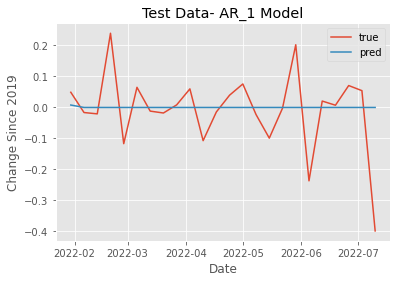

In [143]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(DAL_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- AR_1 Model')

plt.legend();

## New Orleans Modeling

In [144]:
# Define train and test sets according to the index cutoff
# using the same index cutoff as NY because all cities have the same number of rows
NOLA_train = NOLA_new[:cutoff]
NOLA_test = NOLA_new[cutoff:]

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


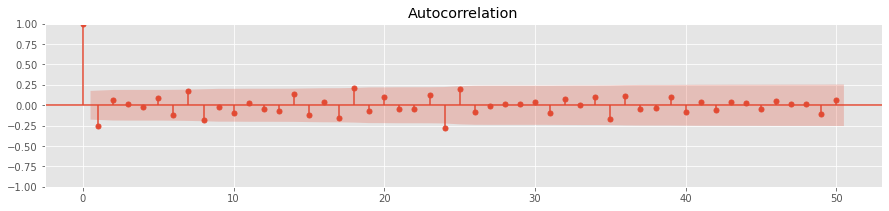

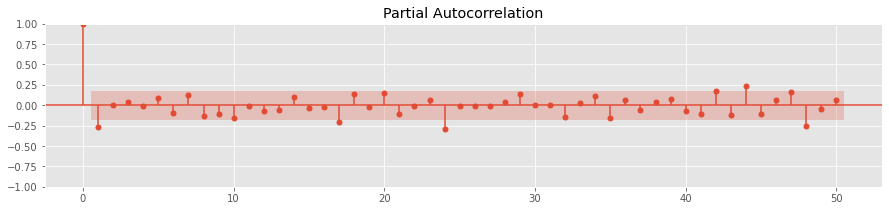

In [145]:
#look at autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(figsize=(15,3))
plot_acf(NOLA_new, ax=ax, lags=50);

fig, ax = plt.subplots(figsize=(15,3))
plot_pacf(NOLA_new, ax=ax, lags=50);

In [146]:
#Baseline Model

NOLA_naive = NOLA_train.shift(1).dropna()
NOLA_naive.head()

2020-03-08   -0.28
2020-03-15    0.13
2020-03-22   -0.25
2020-03-29   -0.72
2020-04-05    0.00
Freq: W-SUN, Name: New Orleans, dtype: float64

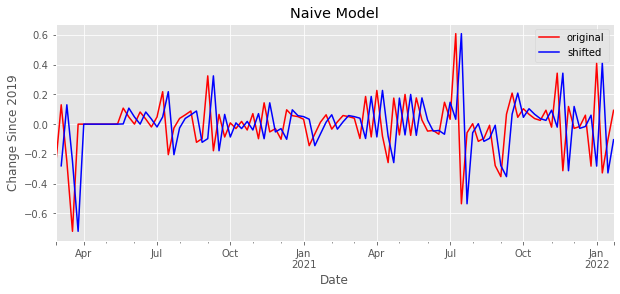

In [147]:
fig, ax = plt.subplots(figsize=(10, 4))

NOLA_train[0:200].plot(ax=ax, c='r', label='original')
NOLA_naive[0:200].plot(ax=ax, c='b', label='shifted')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Naive Model')
ax.legend();

In [148]:
NOLA_naive_rmse = np.sqrt(mean_squared_error(NOLA_train[1:], NOLA_naive.dropna()))
NOLA_naive_rmse

0.2717849534265849

In [149]:
#First ARIMA model based on the autocorrelation and partial autocorrelation plots
NOLA_AR_1 = ARIMA(NOLA_train, order=(0, 0, 1)).fit()  
print(NOLA_AR_1.summary())

                               SARIMAX Results                                
Dep. Variable:            New Orleans   No. Observations:                  100
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  36.873
Date:                Thu, 07 Jul 2022   AIC                            -67.746
Time:                        22:41:43   BIC                            -59.930
Sample:                    03-01-2020   HQIC                           -64.583
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0047      0.013     -0.355      0.723      -0.031       0.021
ma.L1         -0.2303      0.073     -3.161      0.002      -0.373      -0.088
sigma2         0.0280      0.002     12.516      0.0

In [150]:
train_preds_1 = NOLA_AR_1.predict(typ='levels')
test_preds_1 = NOLA_AR_1.predict(start=NOLA_test.index[0], end=NOLA_test.index[-1],typ='levels')

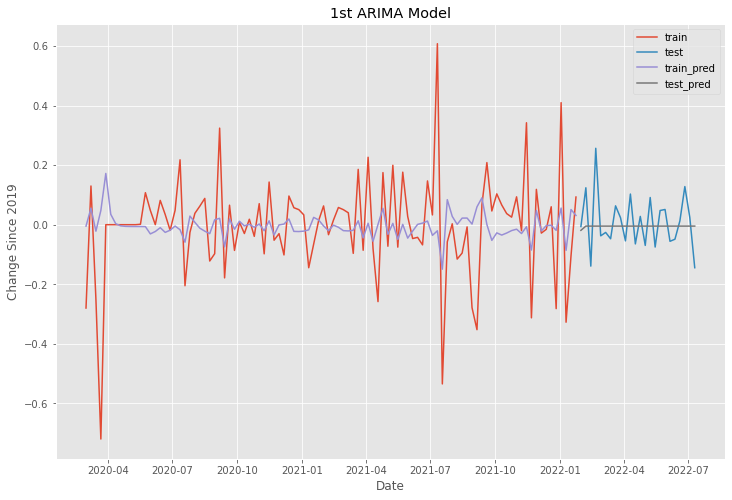

In [151]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(NOLA_train, label='train')
ax.plot(NOLA_test, label='test')
ax.plot(train_preds_1, label='train_pred')
ax.plot(test_preds_1, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('1st ARIMA Model')
plt.legend();

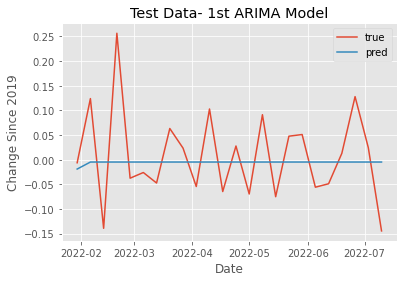

In [152]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(NOLA_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 1st ARIMA Model')

plt.legend();

In [153]:
NOLA_AR_1_RMSE = np.sqrt(mean_squared_error(NOLA_test, test_preds_1))
NOLA_AR_1_RMSE

0.09075630623826686

In [154]:
#Use auto_model tool to find the optimal ARIMA model 

auto_model = pm.auto_arima(NOLA_train, start_p=1, start_q=1,
                      test='adf',       
                      max_p=10, max_q=10,
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-68.104, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-65.796, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-70.104, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-69.612, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-68.104, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-66.153, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-68.234, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.187 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  37.052
Date:                Thu, 07 Jul 2022   AIC                            -70.104
Time:                        22:41:44   BIC                            -64.893
Sample:                       

In [155]:
#2nd ARIMA model given the autocorrelation graph above 
NOLA_AR_2 = ARIMA(NOLA_train, order=(1,0,0)).fit()  
print(NOLA_AR_2.summary())

                               SARIMAX Results                                
Dep. Variable:            New Orleans   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  37.117
Date:                Thu, 07 Jul 2022   AIC                            -68.234
Time:                        22:41:44   BIC                            -60.419
Sample:                    03-01-2020   HQIC                           -65.071
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0048      0.014     -0.346      0.729      -0.032       0.023
ar.L1         -0.2503      0.073     -3.433      0.001      -0.393      -0.107
sigma2         0.0278      0.002     12.627      0.0

In [156]:
train_preds_2 = NOLA_AR_2.predict(typ='levels')
test_preds_2 = NOLA_AR_2.predict(start=NOLA_test.index[0], end=NOLA_test.index[-1],typ='levels')

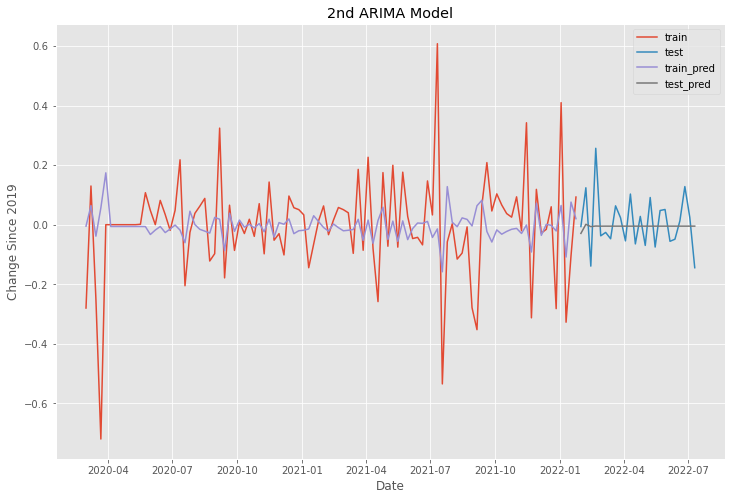

In [157]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(NOLA_train, label='train')
ax.plot(NOLA_test, label='test')
ax.plot(train_preds_2, label='train_pred')
ax.plot(test_preds_2, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('2nd ARIMA Model')

plt.legend();

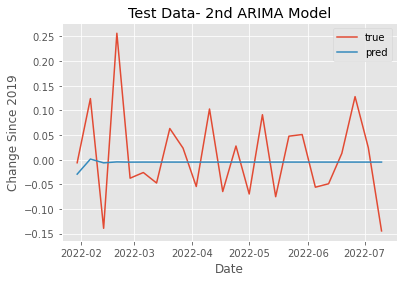

In [158]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(NOLA_test, label='true')
ax.plot(test_preds_2, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 2nd ARIMA Model')

plt.legend();

In [159]:
NOLA_AR_2_RMSE = np.sqrt(mean_squared_error(NOLA_test, test_preds_2))
NOLA_AR_2_RMSE

0.09036135842806801

In [160]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(NOLA_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=8,
                         start_P=0, seasonal=True,
                         d=0, trace=True, stationary = True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[8] intercept   : AIC=-69.310, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[8] intercept   : AIC=-63.887, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[8] intercept   : AIC=-69.446, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[8] intercept   : AIC=-70.841, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[8]             : AIC=-65.796, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[8] intercept   : AIC=-67.746, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[8] intercept   : AIC=-72.545, Time=0.13 sec
 ARIMA(0,0,1)(1,0,0)[8] intercept   : AIC=-69.255, Time=0.05 sec
 ARIMA(0,0,1)(2,0,1)[8] intercept   : AIC=-70.678, Time=0.30 sec
 ARIMA(0,0,1)(1,0,2)[8] intercept   : AIC=-70.611, Time=0.27 sec
 ARIMA(0,0,1)(0,0,2)[8] intercept   : AIC=-71.447, Time=0.19 sec
 ARIMA(0,0,1)(2,0,0)[8] intercept   : AIC=-67.790, Time=0.18 sec
 ARIMA(0,0,1)(2,0,2)[8] intercept   : AIC=-69.135, Time=0.41 sec
 ARIMA(0,0,0)(1,0,1)[8] intercept   : AIC=-66.492, Time=0.11 sec
 ARIMA(1,0,1)(1,0,1)[8] intercept   : AIC=-71.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  100
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 8)   Log Likelihood                  41.941
Date:                             Thu, 07 Jul 2022   AIC                            -75.882
Time:                                     22:41:50   BIC                            -65.461
Sample:                                          0   HQIC                           -71.664
                                             - 100                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3199      0.079     -4.051      0.000      -0.475      -0.165
ar.S.L8        0.4550      0.244      1.864      0.062      -0.024       0.933
ma.S.L8       -0.8032      0.196     -4.091      0.000      -1.188      -0.418
sigma2         0.0246      0.002     13.347      0.000       0.021       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               177.96
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                            -0.17
Prob(H) (two-sided):                  0.45   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [161]:
NOLA_SARIMA =SARIMAX(NOLA_train,
                  order=(1,0,0),
                  seasonal_order=(1,0,1,8),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
print(NOLA_SARIMA.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         New Orleans   No. Observations:                  100
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 8)   Log Likelihood                  47.298
Date:                             Thu, 07 Jul 2022   AIC                            -86.596
Time:                                     22:41:50   BIC                            -76.553
Sample:                                 03-01-2020   HQIC                           -82.544
                                      - 01-23-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3873      0.080     -4.842      0.000      -0.544      -0.231
ar.S.L8       -0.0602      

In [162]:
train_preds_3 = NOLA_SARIMA.predict(typ='levels')
test_preds_3 = NOLA_SARIMA.predict(start=NOLA_test.index[0], end=NOLA_test.index[-1],typ='levels')

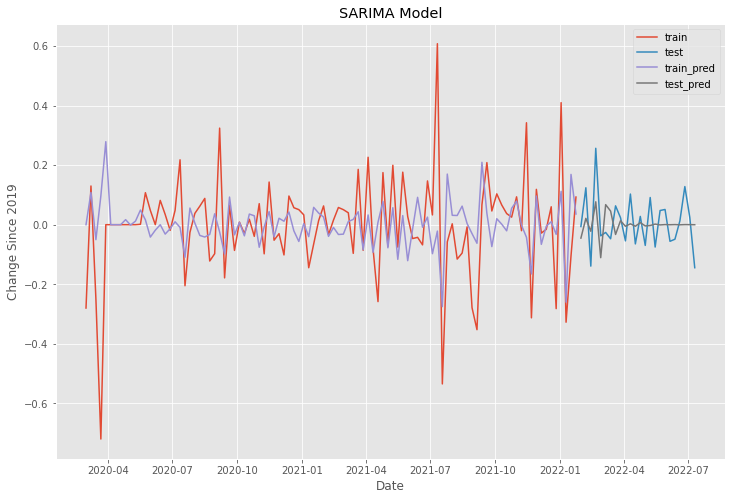

In [163]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(NOLA_train, label='train')
ax.plot(NOLA_test, label='test')
ax.plot(train_preds_3, label='train_pred')
ax.plot(test_preds_3, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('SARIMA Model')

plt.legend();

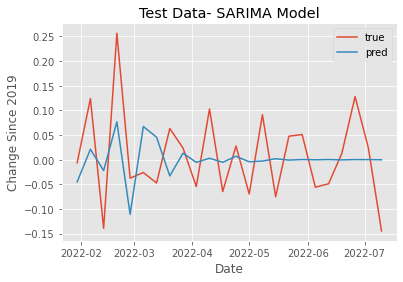

In [164]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(NOLA_test, label='true')
ax.plot(test_preds_3, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- SARIMA Model')

plt.legend();

In [165]:
NOLA_SARIMA_RMSE = np.sqrt(mean_squared_error(NOLA_test, test_preds_3))
NOLA_SARIMA_RMSE

0.08513431363736616

In [166]:
#compiled test scores

In [167]:
print(f'AR_1 AIC: {NOLA_AR_1.aic}' )
print(f'AR_2 AIC: {NOLA_AR_2.aic}' )
print(f'SMODEL AIC: {NOLA_SARIMA.aic}' )

AR_1 AIC: -67.74571526972629
AR_2 AIC: -68.23419042282174
SMODEL AIC: -86.59600507401888


In [168]:
print(f'Naive RMSE: {NOLA_naive_rmse}')
print(f'AR_1 RMSE: {NOLA_AR_1_RMSE}' )
print(f'AR_2 RMSE: {NOLA_AR_2_RMSE}' )
print(f'SMODEL RMSE: {NOLA_SARIMA_RMSE}' )

Naive RMSE: 0.2717849534265849
AR_1 RMSE: 0.09075630623826686
AR_2 RMSE: 0.09036135842806801
SMODEL RMSE: 0.08513431363736616


In [169]:
#final model- AR_1

Even though the SMODEL had the highest AIC, I chose to use AR_1 as my final model because it had a lower RMSE

In [170]:
#Forecast Error
forecast_error = (NOLA_test- test_preds_1)
forecast_error

2022-01-30    0.01
2022-02-06    0.13
2022-02-13   -0.13
2022-02-20    0.26
2022-02-27   -0.03
2022-03-06   -0.02
2022-03-13   -0.04
2022-03-20    0.07
2022-03-27    0.03
2022-04-03   -0.05
2022-04-10    0.11
2022-04-17   -0.06
2022-04-24    0.03
2022-05-01   -0.06
2022-05-08    0.10
2022-05-15   -0.07
2022-05-22    0.05
2022-05-29    0.06
2022-06-05   -0.05
2022-06-12   -0.04
2022-06-19    0.02
2022-06-26    0.13
2022-07-03    0.03
2022-07-10   -0.14
Freq: W-SUN, dtype: float64

In [171]:
#Mean Forecast Error
mean_forecast_error = (NOLA_test - test_preds_1).mean()
mean_forecast_error

0.013010765621540918

In [172]:
df_forecast=pd.concat([NOLA_test, test_preds_1, forecast_error],axis=1)
df_forecast.columns = ['True Test', 'Predicted Test', 'Difference']
df_forecast

True Test  Predicted Test  Difference
2022-01-30      -0.01           -0.02        0.01
2022-02-06       0.12           -0.00        0.13
2022-02-13      -0.14           -0.00       -0.13
2022-02-20       0.26           -0.00        0.26
2022-02-27      -0.04           -0.00       -0.03
2022-03-06      -0.03           -0.00       -0.02
2022-03-13      -0.05           -0.00       -0.04
2022-03-20       0.06           -0.00        0.07
2022-03-27       0.02           -0.00        0.03
2022-04-03      -0.05           -0.00       -0.05
2022-04-10       0.10           -0.00        0.11
2022-04-17      -0.06           -0.00       -0.06
2022-04-24       0.03           -0.00        0.03
2022-05-01      -0.07           -0.00       -0.06
2022-05-08       0.09           -0.00        0.10
2022-05-15      -0.08           -0.00       -0.07
2022-05-22       0.05           -0.00        0.05
2022-05-29       0.05           -0.00        0.06
2022-06-05      -0.06           -0.00       -0.05
2022-06-12      -0.05           -0.00       -0.04
2022-06-19       0.01           -0.00        0.02
2022-06-26       0.13           -0.00        0.13
2022-07-03       0.02           -0.00        0.03
2022-07-10      -0.14           -0.00       -0.14

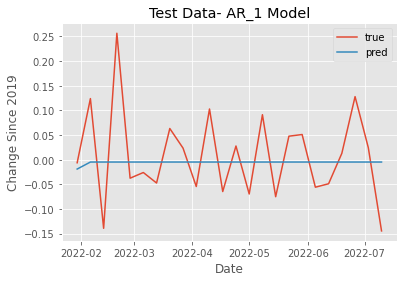

In [173]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(NOLA_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- AR_1 Model')

plt.legend();

## Miami Forecasting

In [174]:
# Define train and test sets according to the index cutoff
# using the same index cutoff as NY because all cities have the same number of rows
MIA_train = MIA_new[:cutoff]
MIA_test = MIA_new[cutoff:]

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


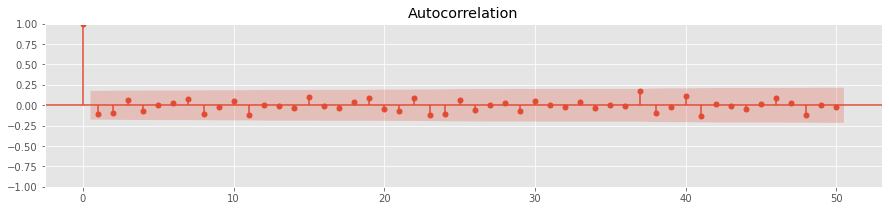

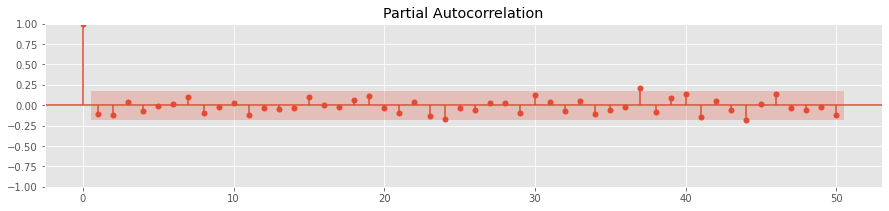

In [175]:
#look at autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(figsize=(15,3))
plot_acf(MIA_new, ax=ax, lags=50);

fig, ax = plt.subplots(figsize=(15,3))
plot_pacf(MIA_new, ax=ax, lags=50);

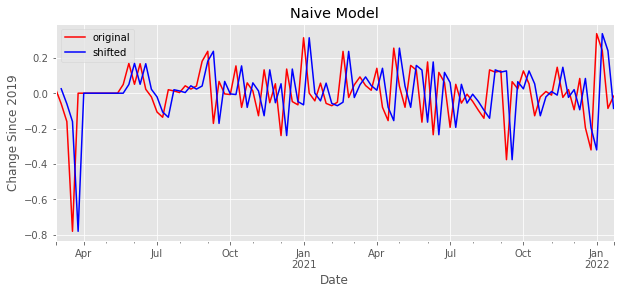

In [176]:
#Baseline Model
MIA_naive = MIA_train.shift(1).dropna()
MIA_naive.head()

fig, ax = plt.subplots(figsize=(10, 4))

MIA_train[0:200].plot(ax=ax, c='r', label='original')
MIA_naive[0:200].plot(ax=ax, c='b', label='shifted')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Naive Model')
ax.legend();

In [177]:
MIA_naive_rmse = np.sqrt(mean_squared_error(MIA_train[1:], MIA_naive.dropna()))
MIA_naive_rmse

0.21572785324724914

In [178]:
#First ARIMA model based on the autocorrelation and partial autocorrelation plots
MIA_AR_1 = ARIMA(MIA_train, order=(0, 0, 1)).fit()  
print(MIA_AR_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Miami   No. Observations:                  100
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  50.412
Date:                Thu, 07 Jul 2022   AIC                            -94.824
Time:                        22:41:50   BIC                            -87.008
Sample:                    03-01-2020   HQIC                           -91.661
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.016      0.154      0.878      -0.028       0.033
ma.L1         -0.0861      0.099     -0.865      0.387      -0.281       0.109
sigma2         0.0214      0.002     12.352      0.0

In [179]:
train_preds_1 = MIA_AR_1.predict(typ='levels')
test_preds_1 = MIA_AR_1.predict(start=MIA_test.index[0], end=MIA_test.index[-1],typ='levels')

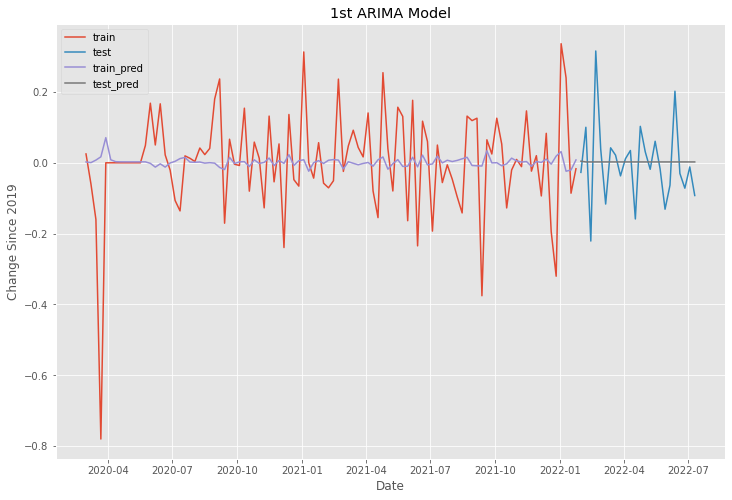

In [180]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(MIA_train, label='train')
ax.plot(MIA_test, label='test')
ax.plot(train_preds_1, label='train_pred')
ax.plot(test_preds_1, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('1st ARIMA Model')
plt.legend();

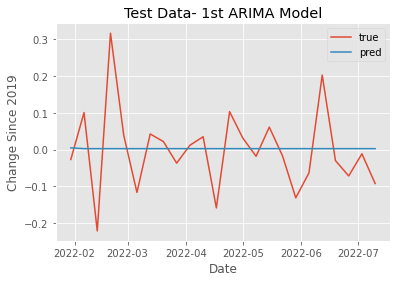

In [181]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(MIA_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 1st ARIMA Model')

plt.legend();

In [182]:
MIA_AR_1_RMSE = np.sqrt(mean_squared_error(MIA_test, test_preds_1))
MIA_AR_1_RMSE

0.11134922737811134

In [183]:
#Use auto_model tool to find the optimal ARIMA model 

auto_model = pm.auto_arima(MIA_train, start_p=1, start_q=1,
                      test='adf',       
                      max_p=10, max_q=10,
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-95.456, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-98.174, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-96.683, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-96.791, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-96.201, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.148 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                        SARIMAX   Log Likelihood                  50.087
Date:                Thu, 07 Jul 2022   AIC                            -98.174
Time:                        22:41:51   BIC                            -95.569
Sample:                             0   HQIC                           -97.120
                                - 100                                         
Co

In [184]:
#2nd ARIMA model given the autocorrelation graph above 
MIA_AR_2 = ARIMA(MIA_train, order=(0,0,0)).fit()  
print(MIA_AR_2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Miami   No. Observations:                  100
Model:                          ARIMA   Log Likelihood                  50.101
Date:                Thu, 07 Jul 2022   AIC                            -96.201
Time:                        22:41:51   BIC                            -90.991
Sample:                    03-01-2020   HQIC                           -94.092
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.017      0.142      0.887      -0.031       0.036
sigma2         0.0215      0.002     13.028      0.000       0.018       0.025
Ljung-Box (L1) (Q):                   0.53   Jarque-

In [185]:
train_preds_2 = MIA_AR_2.predict(typ='levels')
test_preds_2 = MIA_AR_2.predict(start=MIA_test.index[0], end=MIA_test.index[-1],typ='levels')

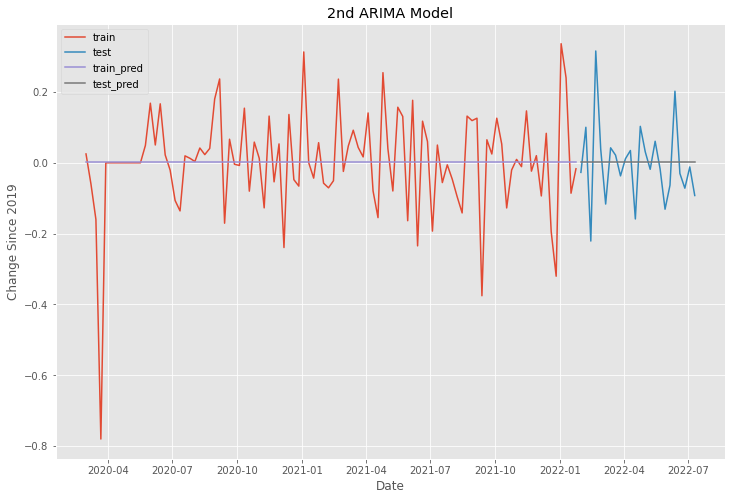

In [186]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(MIA_train, label='train')
ax.plot(MIA_test, label='test')
ax.plot(train_preds_2, label='train_pred')
ax.plot(test_preds_2, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('2nd ARIMA Model')

plt.legend();

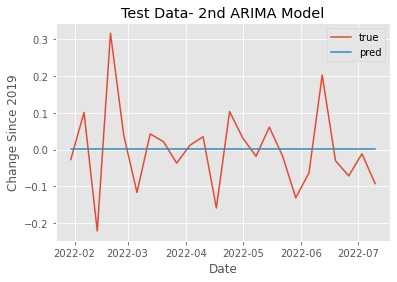

In [187]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(MIA_test, label='true')
ax.plot(test_preds_2, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 2nd ARIMA Model')

plt.legend();

In [188]:
MIA_AR_2_RMSE = np.sqrt(mean_squared_error(MIA_test, test_preds_2))
MIA_AR_2_RMSE

0.11132445997364936

In [189]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(MIA_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=8,
                         start_P=0, seasonal=True,
                         d=0, trace=True, stationary = True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[8] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[8] intercept   : AIC=-96.201, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[8] intercept   : AIC=-93.075, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[8] intercept   : AIC=-93.302, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[8]             : AIC=-98.174, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[8] intercept   : AIC=-94.552, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[8] intercept   : AIC=-94.679, Time=0.02 sec
 ARIMA(0,0,0)(1,0,1)[8] intercept   : AIC=-94.113, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[8] intercept   : AIC=-94.714, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[8] intercept   : AIC=-94.824, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[8] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[8]          
Total fit time: 0.604 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                        SARIMAX   Log Likelihood                  50.087
Date:                Thu, 07 Jul 2022   AIC                            -98.174
Time:                        22:41:52   BIC                            -95.569
Sample:                             0   HQIC                           -97.120
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0215      0.001     14.930      0.000       0.019       0.024
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):               242.40
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -1.49
Prob(H) (two-sided):                  0.60   Kurtosis:                        10.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [190]:
MIA_SARIMA =SARIMAX(MIA_train,
                  order=(0,0,0),
                  seasonal_order=(1,0,1,8),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
print(MIA_SARIMA.summary())

                                 SARIMAX Results                                 
Dep. Variable:                     Miami   No. Observations:                  100
Model:             SARIMAX(1, 0, [1], 8)   Log Likelihood                  57.808
Date:                   Thu, 07 Jul 2022   AIC                           -109.616
Time:                           22:41:52   BIC                           -102.084
Sample:                       03-01-2020   HQIC                          -106.577
                            - 01-23-2022                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L8        0.0665      0.291      0.228      0.819      -0.504       0.638
ma.S.L8       -0.2230      0.293     -0.762      0.446      -0.797       0.351
sigma2         0.0164      0

In [191]:
train_preds_3 = MIA_SARIMA.predict(typ='levels')
test_preds_3 = MIA_SARIMA.predict(start=MIA_test.index[0], end=MIA_test.index[-1],typ='levels')

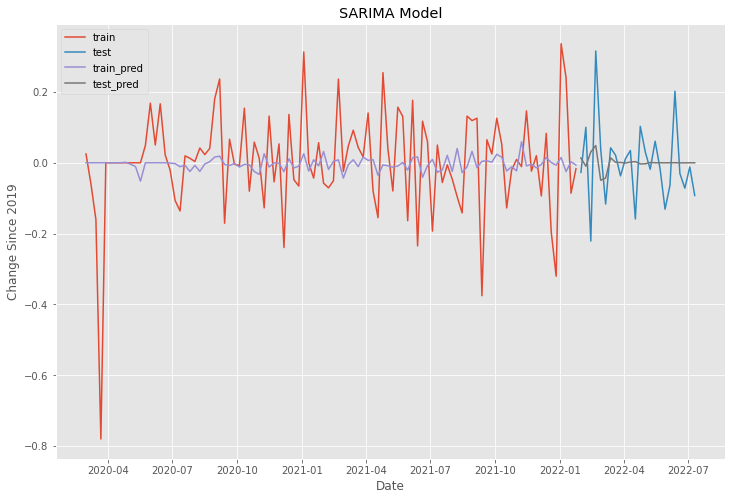

In [192]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(MIA_train, label='train')
ax.plot(MIA_test, label='test')
ax.plot(train_preds_3, label='train_pred')
ax.plot(test_preds_3, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('SARIMA Model')

plt.legend();

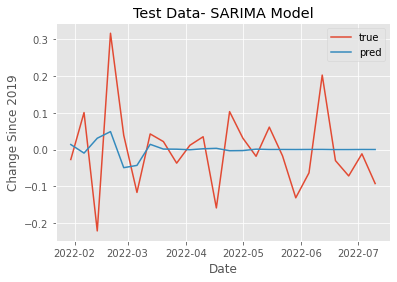

In [193]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(MIA_test, label='true')
ax.plot(test_preds_3, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- SARIMA Model')

plt.legend();

In [194]:
MIA_SARIMA_RMSE = np.sqrt(mean_squared_error(MIA_test, test_preds_3))
MIA_SARIMA_RMSE

0.10897483108633466

In [195]:
#compiled test scores

In [196]:
print(f'AR_1 AIC: {MIA_AR_1.aic}' )
print(f'AR_2 AIC: {MIA_AR_2.aic}' )
print(f'SMODEL AIC: {MIA_SARIMA.aic}' )

AR_1 AIC: -94.82378147100006
AR_2 AIC: -96.20120161043602
SMODEL AIC: -109.6162933292789


In [197]:
print(f'Naive RMSE: {MIA_naive_rmse}')
print(f'AR_1 RMSE: {MIA_AR_1_RMSE}' )
print(f'AR_2 RMSE: {MIA_AR_2_RMSE}' )
print(f'SMODEL RMSE: {MIA_SARIMA_RMSE}' )

Naive RMSE: 0.21572785324724914
AR_1 RMSE: 0.11134922737811134
AR_2 RMSE: 0.11132445997364936
SMODEL RMSE: 0.10897483108633466


In [198]:
#final model- SARIMA

In [199]:
#Forecast Error
forecast_error = (MIA_test- test_preds_3)
forecast_error

2022-01-30   -0.04
2022-02-06    0.11
2022-02-13   -0.25
2022-02-20    0.27
2022-02-27    0.09
2022-03-06   -0.07
2022-03-13    0.03
2022-03-20    0.02
2022-03-27   -0.04
2022-04-03    0.01
2022-04-10    0.03
2022-04-17   -0.16
2022-04-24    0.11
2022-05-01    0.03
2022-05-08   -0.02
2022-05-15    0.06
2022-05-22   -0.02
2022-05-29   -0.13
2022-06-05   -0.06
2022-06-12    0.20
2022-06-19   -0.03
2022-06-26   -0.07
2022-07-03   -0.01
2022-07-10   -0.09
Freq: W-SUN, dtype: float64

In [200]:
#Mean Forecast Error
mean_forecast_error = (MIA_test - test_preds_3).mean()
mean_forecast_error

-0.001710046088680909

In [201]:
df_forecast=pd.concat([MIA_test, test_preds_1, forecast_error],axis=1)
df_forecast.columns = ['True Test', 'Predicted Test', 'Difference']
df_forecast

True Test  Predicted Test  Difference
2022-01-30      -0.03            0.00       -0.04
2022-02-06       0.10            0.00        0.11
2022-02-13      -0.22            0.00       -0.25
2022-02-20       0.32            0.00        0.27
2022-02-27       0.04            0.00        0.09
2022-03-06      -0.12            0.00       -0.07
2022-03-13       0.04            0.00        0.03
2022-03-20       0.02            0.00        0.02
2022-03-27      -0.04            0.00       -0.04
2022-04-03       0.01            0.00        0.01
2022-04-10       0.03            0.00        0.03
2022-04-17      -0.16            0.00       -0.16
2022-04-24       0.10            0.00        0.11
2022-05-01       0.03            0.00        0.03
2022-05-08      -0.02            0.00       -0.02
2022-05-15       0.06            0.00        0.06
2022-05-22      -0.02            0.00       -0.02
2022-05-29      -0.13            0.00       -0.13
2022-06-05      -0.06            0.00       -0.06
2022-06-12       0.20            0.00        0.20
2022-06-19      -0.03            0.00       -0.03
2022-06-26      -0.07            0.00       -0.07
2022-07-03      -0.01            0.00       -0.01
2022-07-10      -0.09            0.00       -0.09

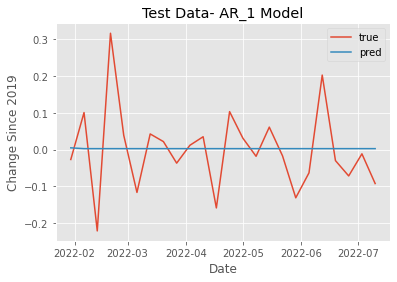

In [202]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(MIA_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- AR_1 Model')

plt.legend();

## Phoenix Modeling

In [203]:
# Define train and test sets according to the index cutoff
# using the same index cutoff as NY because all cities have the same number of rows
PHO_train = PHO_new[:cutoff]
PHO_test = PHO_new[cutoff:]

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


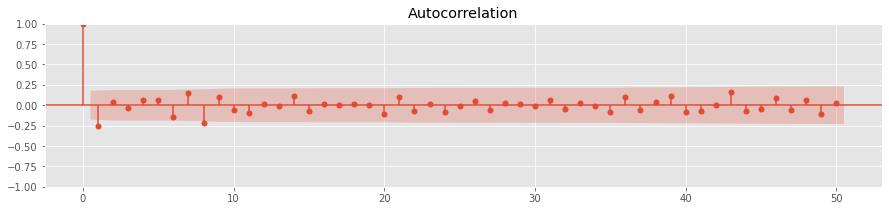

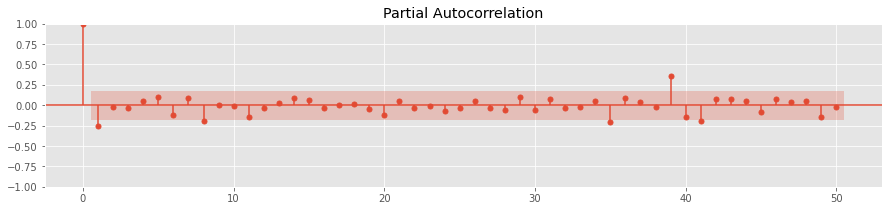

In [204]:
#look at autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(figsize=(15,3))
plot_acf(PHO_new, ax=ax, lags=50);

fig, ax = plt.subplots(figsize=(15,3))
plot_pacf(PHO_new, ax=ax, lags=50);

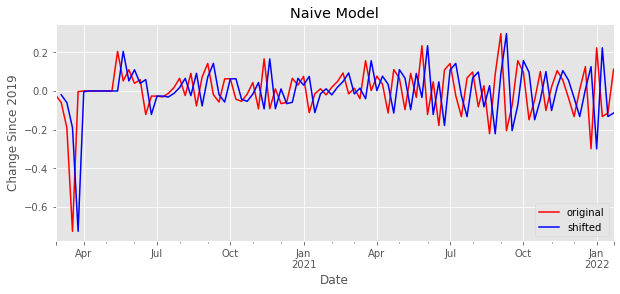

In [205]:
#Baseline Model
PHO_naive = PHO_train.shift(1).dropna()
PHO_naive.head()

fig, ax = plt.subplots(figsize=(10, 4))

PHO_train[0:200].plot(ax=ax, c='r', label='original')
PHO_naive[0:200].plot(ax=ax, c='b', label='shifted')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Naive Model')
ax.legend();

In [206]:
PHO_naive_rmse = np.sqrt(mean_squared_error(PHO_train[1:], PHO_naive.dropna()))
PHO_naive_rmse

0.1857072130798882

In [207]:
#First ARIMA model based on the autocorrelation and partial autocorrelation plots
PHO_AR_1 = ARIMA(PHO_train, order=(0, 0, 1)).fit()  
print(PHO_AR_1.summary())

                               SARIMAX Results                                
Dep. Variable:                Phoenix   No. Observations:                  100
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  66.712
Date:                Thu, 07 Jul 2022   AIC                           -127.423
Time:                        22:41:53   BIC                           -119.608
Sample:                    03-01-2020   HQIC                          -124.260
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.013     -0.087      0.931      -0.027       0.025
ma.L1         -0.1113      0.110     -1.010      0.312      -0.327       0.105
sigma2         0.0154      0.001     11.832      0.0

In [208]:
train_preds_1 = PHO_AR_1.predict(typ='levels')
test_preds_1 = PHO_AR_1.predict(start=PHO_test.index[0], end=PHO_test.index[-1],typ='levels')

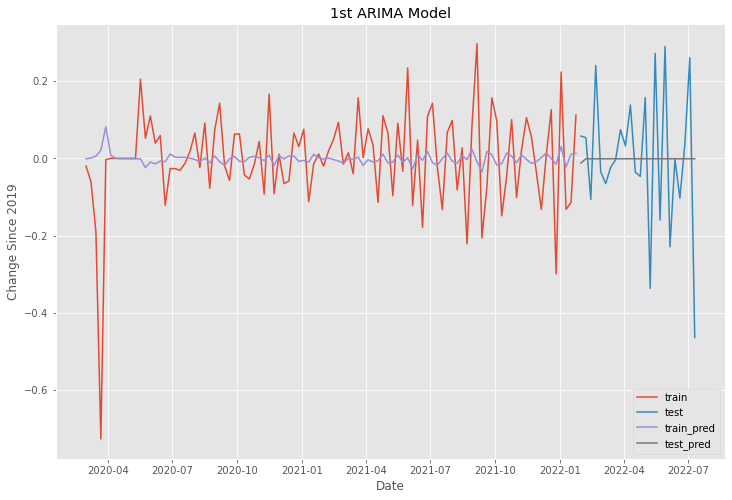

In [209]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(PHO_train, label='train')
ax.plot(PHO_test, label='test')
ax.plot(train_preds_1, label='train_pred')
ax.plot(test_preds_1, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('1st ARIMA Model')
plt.legend();

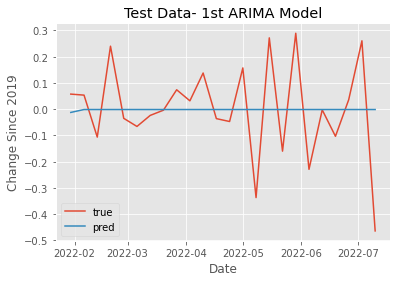

In [210]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(PHO_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 1st ARIMA Model')

plt.legend();

In [211]:
PHO_AR_1_RMSE = np.sqrt(mean_squared_error(PHO_test, test_preds_1))
PHO_AR_1_RMSE

0.18026808942322742

In [212]:
#Use auto_model tool to find the optimal ARIMA model 

auto_model = pm.auto_arima(PHO_train, start_p=1, start_q=1,
                      test='adf',       
                      max_p=10, max_q=10,
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-127.501, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-130.297, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-129.278, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-129.412, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-128.305, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.081 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                        SARIMAX   Log Likelihood                  66.149
Date:                Thu, 07 Jul 2022   AIC                           -130.297
Time:                        22:41:53   BIC                           -127.692
Sample:                             0   HQIC                          -129.243
                                - 100                                       

In [213]:
#2nd ARIMA model given the autocorrelation graph above 
PHO_AR_2 = ARIMA(PHO_train, order=(0,0,0)).fit()  
print(PHO_AR_2.summary())

                               SARIMAX Results                                
Dep. Variable:                Phoenix   No. Observations:                  100
Model:                          ARIMA   Log Likelihood                  66.152
Date:                Thu, 07 Jul 2022   AIC                           -128.305
Time:                        22:41:53   BIC                           -123.094
Sample:                    03-01-2020   HQIC                          -126.196
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.015     -0.072      0.942      -0.030       0.028
sigma2         0.0156      0.001     14.457      0.000       0.013       0.018
Ljung-Box (L1) (Q):                   1.01   Jarque-

In [214]:
train_preds_2 = PHO_AR_2.predict(typ='levels')
test_preds_2 = PHO_AR_2.predict(start=PHO_test.index[0], end=PHO_test.index[-1],typ='levels')

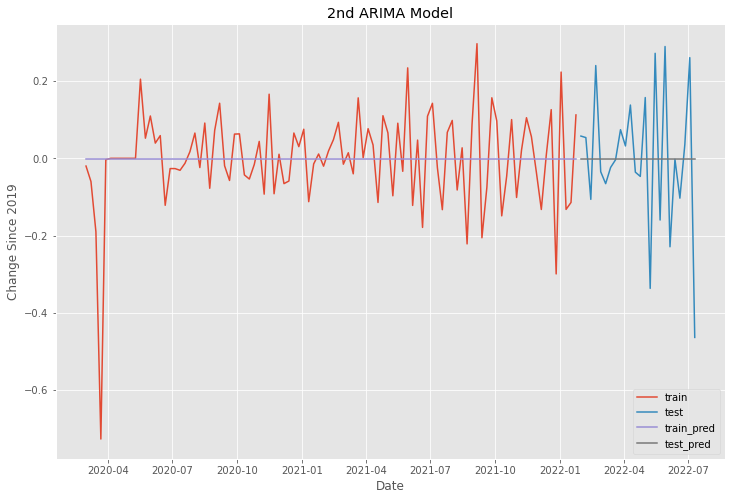

In [215]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(PHO_train, label='train')
ax.plot(PHO_test, label='test')
ax.plot(train_preds_2, label='train_pred')
ax.plot(test_preds_2, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('2nd ARIMA Model')

plt.legend();

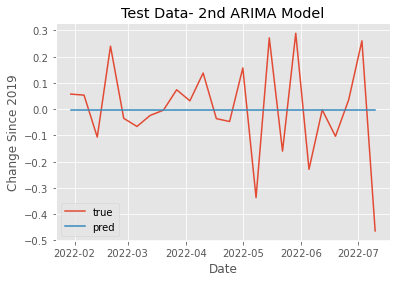

In [216]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(PHO_test, label='true')
ax.plot(test_preds_2, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 2nd ARIMA Model')

plt.legend();

In [217]:
PHO_AR_2_RMSE = np.sqrt(mean_squared_error(PHO_test, test_preds_2))
PHO_AR_2_RMSE

0.18010297750609583

In [218]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(PHO_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=8,
                         start_P=0, seasonal=True,
                         d=0, trace=True, stationary = True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[8] intercept   : AIC=-125.824, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[8] intercept   : AIC=-128.305, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[8] intercept   : AIC=-127.316, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[8] intercept   : AIC=-127.577, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[8]             : AIC=-130.297, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[8] intercept   : AIC=-128.272, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[8] intercept   : AIC=-128.342, Time=0.02 sec
 ARIMA(0,0,0)(1,0,1)[8] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[8] intercept   : AIC=-127.289, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[8] intercept   : AIC=-127.423, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[8] intercept   : AIC=-125.511, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[8]          
Total fit time: 0.620 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                        SARIMAX   Log Likelihood                  66.149
Date:                Thu, 07 Jul 2022   AIC                           -130.297
Time:                        22:41:54   BIC                           -127.692
Sample:                             0   HQIC                          -129.243
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0156      0.001     17.303      0.000       0.014       0.017
===================================================================================
Ljung-Box (L1) (Q):                   1.01   Jarque-Bera (JB):               468.64
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.89
Prob(H) (two-sided):                  0.68   Kurtosis:                        12.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [219]:
PHO_SARIMA =SARIMAX(PHO_train,
                  order=(0,0,0),
                  seasonal_order=(0,0,0,8),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
print(PHO_SARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                Phoenix   No. Observations:                  100
Model:                        SARIMAX   Log Likelihood                  65.002
Date:                Thu, 07 Jul 2022   AIC                           -128.005
Time:                        22:41:54   BIC                           -125.410
Sample:                    03-01-2020   HQIC                          -126.955
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0157      0.001     17.128      0.000       0.014       0.018
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):               454.60
Prob(Q):                              0.31   Pr

In [220]:
train_preds_3 = PHO_SARIMA.predict(typ='levels')
test_preds_3 = PHO_SARIMA.predict(start=PHO_test.index[0], end=PHO_test.index[-1],typ='levels')

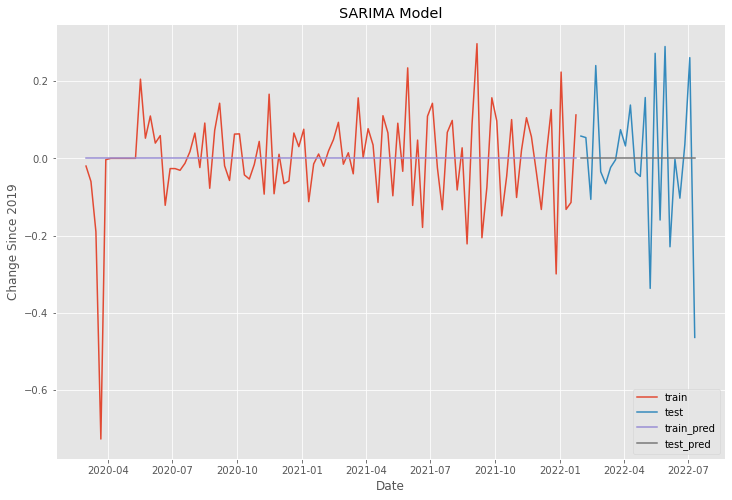

In [221]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(PHO_train, label='train')
ax.plot(PHO_test, label='test')
ax.plot(train_preds_3, label='train_pred')
ax.plot(test_preds_3, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('SARIMA Model')

plt.legend();

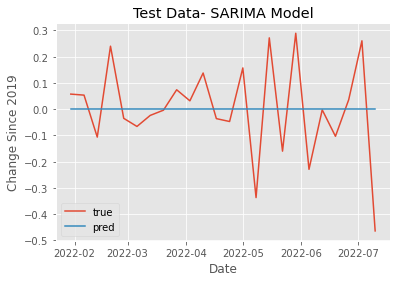

In [222]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(PHO_test, label='true')
ax.plot(test_preds_3, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- SARIMA Model')

plt.legend();

In [223]:
PHO_SARIMA_RMSE = np.sqrt(mean_squared_error(PHO_test, test_preds_3))
PHO_SARIMA_RMSE

0.18009974551157293

In [224]:
#compiled test scores

In [225]:
print(f'AR_1 AIC: {PHO_AR_1.aic}' )
print(f'AR_2 AIC: {PHO_AR_2.aic}' )
print(f'SMODEL AIC: {PHO_SARIMA.aic}' )

AR_1 AIC: -127.42332421866612
AR_2 AIC: -128.30459458831118
SMODEL AIC: -128.00463992084445


In [226]:
print(f'Naive RMSE: {PHO_naive_rmse}')
print(f'AR_1 RMSE: {PHO_AR_1_RMSE}' )
print(f'AR_2 RMSE: {PHO_AR_2_RMSE}' )
print(f'SMODEL RMSE: {PHO_SARIMA_RMSE}' )

Naive RMSE: 0.1857072130798882
AR_1 RMSE: 0.18026808942322742
AR_2 RMSE: 0.18010297750609583
SMODEL RMSE: 0.18009974551157293


In [227]:
#final model- SARIMA

In [228]:
#Forecast Error
forecast_error = (PHO_test- test_preds_3)
forecast_error

2022-01-30    0.06
2022-02-06    0.05
2022-02-13   -0.11
2022-02-20    0.24
2022-02-27   -0.03
2022-03-06   -0.07
2022-03-13   -0.02
2022-03-20   -0.00
2022-03-27    0.07
2022-04-03    0.03
2022-04-10    0.14
2022-04-17   -0.04
2022-04-24   -0.05
2022-05-01    0.16
2022-05-08   -0.34
2022-05-15    0.27
2022-05-22   -0.16
2022-05-29    0.29
2022-06-05   -0.23
2022-06-12   -0.00
2022-06-19   -0.10
2022-06-26    0.04
2022-07-03    0.26
2022-07-10   -0.46
Freq: W-SUN, dtype: float64

In [229]:
#Mean Forecast Error
mean_forecast_error = (PHO_test - test_preds_3).mean()
mean_forecast_error

0.0

In [230]:
df_forecast=pd.concat([PHO_test, test_preds_1, forecast_error],axis=1)
df_forecast.columns = ['True Test', 'Predicted Test', 'Difference']
df_forecast

True Test  Predicted Test  Difference
2022-01-30       0.06           -0.01        0.06
2022-02-06       0.05           -0.00        0.05
2022-02-13      -0.11           -0.00       -0.11
2022-02-20       0.24           -0.00        0.24
2022-02-27      -0.03           -0.00       -0.03
2022-03-06      -0.07           -0.00       -0.07
2022-03-13      -0.02           -0.00       -0.02
2022-03-20      -0.00           -0.00       -0.00
2022-03-27       0.07           -0.00        0.07
2022-04-03       0.03           -0.00        0.03
2022-04-10       0.14           -0.00        0.14
2022-04-17      -0.04           -0.00       -0.04
2022-04-24      -0.05           -0.00       -0.05
2022-05-01       0.16           -0.00        0.16
2022-05-08      -0.34           -0.00       -0.34
2022-05-15       0.27           -0.00        0.27
2022-05-22      -0.16           -0.00       -0.16
2022-05-29       0.29           -0.00        0.29
2022-06-05      -0.23           -0.00       -0.23
2022-06-12      -0.00           -0.00       -0.00
2022-06-19      -0.10           -0.00       -0.10
2022-06-26       0.04           -0.00        0.04
2022-07-03       0.26           -0.00        0.26
2022-07-10      -0.46           -0.00       -0.46

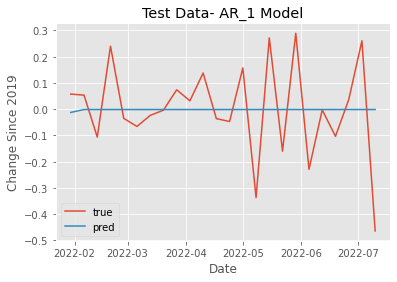

In [231]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(PHO_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- AR_1 Model')

plt.legend();

## Appendix

### LA Train/Test Split

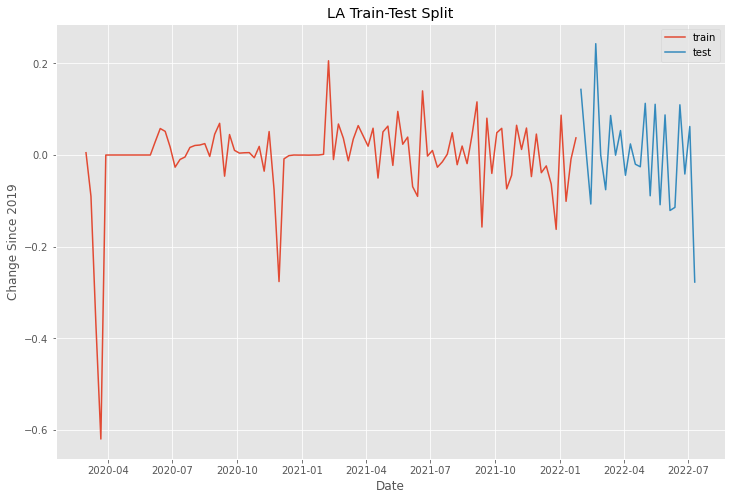

In [232]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(LA_train, label='train')
ax.plot(LA_test, label='test')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('LA Train-Test Split')
plt.legend();

### DAL Train/Test Split

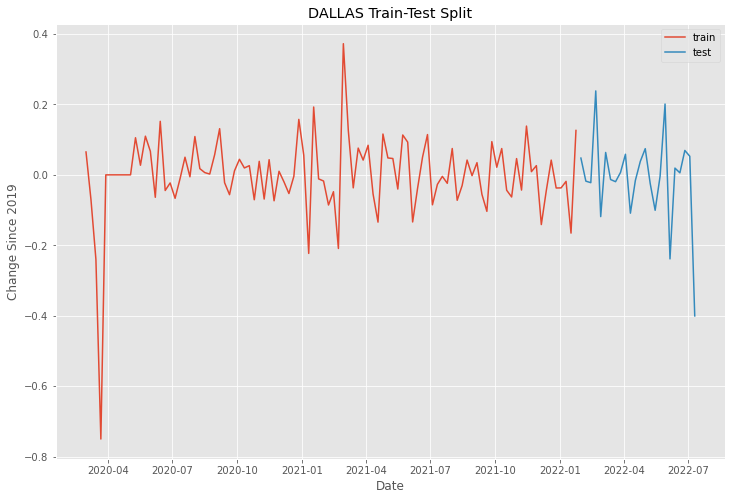

In [233]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(DAL_train, label='train')
ax.plot(DAL_test, label='test')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('DALLAS Train-Test Split')
plt.legend();

### NOLA Train/Test Split

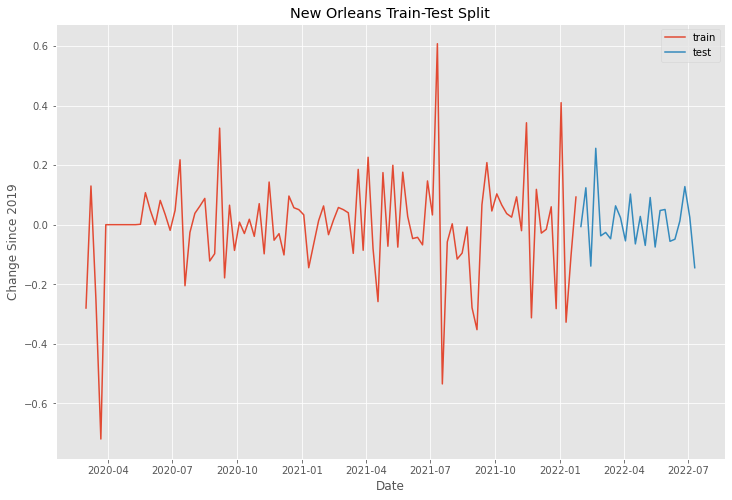

In [234]:
#visualize the train/test split

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(NOLA_train, label='train')
ax.plot(NOLA_test, label='test')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('New Orleans Train-Test Split')
plt.legend();

### MIA Train/Test Split

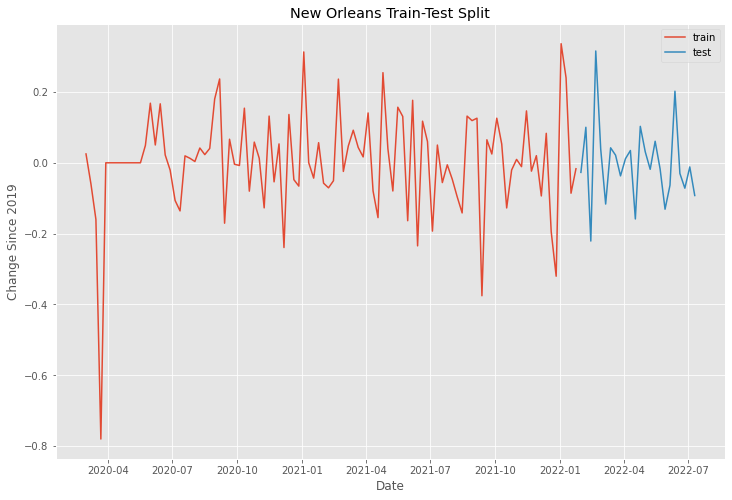

In [235]:
#visualize the train/test split

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(MIA_train, label='train')
ax.plot(MIA_test, label='test')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('New Orleans Train-Test Split')
plt.legend();

### PHO Train/Test Split

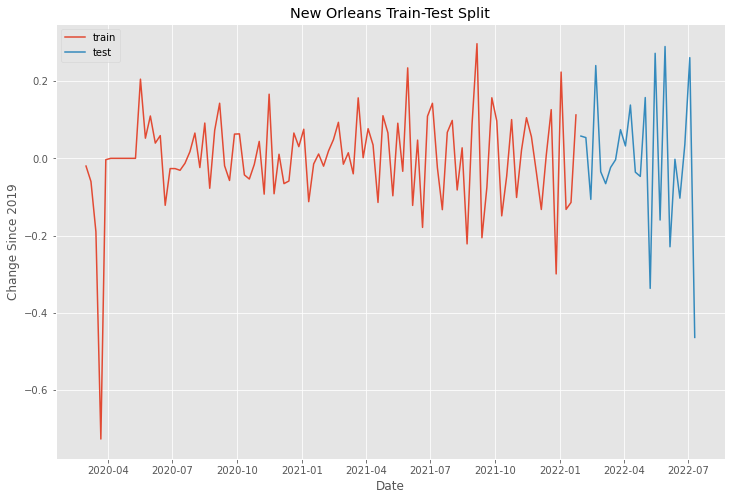

In [236]:
#visualize the train/test split

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(PHO_train, label='train')
ax.plot(PHO_test, label='test')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('New Orleans Train-Test Split')
plt.legend();